# Introductory note
<a id='section0'></a>

This notebook can be downloaded here : [DOWNLOAD](./tutoBW_EV.ipynb)

This is a [Jupyter Notebook](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html) with the purpose of making you familiar with the basic Python-based [Brightway2 LCA framework](https://docs.brightway.dev/en/latest/#) and its various functionalities, all developed by Chris Mutel and colleagues from the Paul Sherrer Institute (PSI).

This tutorial is made for the old version of bw2, and is not meant to handle the new version bw25 (even if the framework remains quite similar). More informations can be found in the [documentation](https://docs.brightway.dev/en/latest/#)

<div class="alert alert-block alert-info">
This notebook is designed to get you started with creating your own project, setting up your database(s) (used as background systems) and simple foreground systems, performing your first impact assessments, analysing your results, and running Monte Carlo simulations in calculation setups.
</div>


<br>

---

The notebook is structured as follows:  

1. [Setup of a project](#section1): *How to set up a project to work in* <br><br>
2. [Database import/setup](#section2): *How to import a database and get it ready for use*<br><br>
3. [My First LCA](#section3): *How to do an LCA on Brightway2*<br><br> 
4. [Contribution analysis](#section4): *How to examine the LCA results* <br><br>
5. [Edit model & Parametrization](#section5): *How create, modify and parametrize activities?*<br><br>
6. [Scenarios analysis](#section6): *How to build and compare LCA scenarios?*<br><br>  
---

**Outcomes - what are we going to learn?**

By completing this notebook (run it locally on your machine and don't just read the code), we will:
- have understood the basics of the Brightway2 LCA framework
- know how to import/generate/handle datasets in Brightway2
- be able to run simple LCAs
- be able to parametriz an inventory
- be able to analyse a product system and the results of an LCA
- be able to visualise data in form of tables and figures

<br>

---
Just for clarification, abbreviations used in the markdown cells of this notebook are:

| Abbreviation(s) | Written out |
| --- | --- |
| bw, BW2 | Brightway2 |
| FU | Functional unit |
| LCA | Life cycle assessment |
| LCI | Life cycle inventory |
| LCIA | Life cycle impact assessment |

---

**Recap on LCA**

To make sure we are on the same page, let's recapitulate the basics of LCA, expressed in a single formula (the notation may differ to the one that you are familiar with):

$$h = CBA^{-1}f$$

where:
- $A$... technosphere matrix (dimensions *p x p*)
- $B$... biosphere matrix (dimensions *q x p*)
- $C$... characterisation matrix (dimensions *r x q*)
- $f$... final demand vector (dimensions *p x 1*)
- $h$... characterised inventory matrix (dimensions *r x 1*)

with the dimensions being:
- *p*... number of products/processes
- *q*... number of elementary flows
- *r*... number of impact categories

Specific parts of the above formula have distinct names. Since these names are also used in the Brightway2-framework, we will note them down here:
- $f$... demand array
- $A{^-1}f$... supply array
- $BA{^-1}f$... inventory referred sometimes as b
- $CBA{^-1}f$... characterised inventory

<br>


<a id='section1'></a>
# 1. Setup of a project

A project gets instantiated and relevant libraries/modules imported.

## 1.1. Import libraries

Import some useful libraries for data vizualisation, scientific computation 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Import now brightway libraries that are split into sublibraries :
- ``Brightway2-data`` handles storing and searching all data sources (databases, LCIA methods, etc.).
- ``Brightway2-calc`` does LCA calculations.
- ``Brightway2-io`` tools for the import, export, and management of inventory databases and impact assessment methods. LCA calculations.
- ``Brightway2-analyzer`` analyzes input data like databases and methods, as well as the result of LCA calculations.
- ``Brightway2-parameters`` Library for storing, validating, and calculating with parameters.

> it is better to import these libraries separately rather than a brutal ``from brightway2 import *`` since with the upcoming update bw25, this will not work anymore.- 

In [2]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc

We will import also ``lca_algebraic`` developped by [OIE mines paristech](https://github.com/oie-mines-paristech/lca_algebraic/)

**lca-algebraic** is a small libray above **brightway2**, designed for the definition of **parametric inventories** with fast computation of LCA impacts, suitable for **monte-carlo** analyis.

<div class="alert alert-block alert-success">

**lca-algebraic** provides a set of  **helper functions** for : 
* **compact** & **human readable** definition of activites :  
    * search background (tech and biosphere) activities 
    * create new foreground activites with parametrized amounts
    * parametrize / update existing background activities (extending the class **Activity**)
* Definition of parameters
* Computation of LCAs 
* Computation of **statistics** (including sensitivity analysis: OAT and GSA with Sobols indices)
* Compute **simplified parametric model** by fixing minor input parameters

In [3]:
import lca_algebraic as agb #import the library
agb.resetParams()

## 1.2. Creation of the project

Let's list the available projects. This project is at the top level of the BW hierarchy. A project is self-contained, with its own copy of data, LCIA methods, calculations, assumptions, and any other data you need. Each project is completely independent of other projects.Projects are saved as subdirectories in the file system.

<img src="images/project.webp"  width="500" style="display: block; margin: 0 auto">

We can get more information (installed databases and file sizes) on the individual projects... and also see where they are stored with the following command. (you might need to dig into this folder if any persisting troubles)

In [4]:
bd.projects.dir

WindowsPath('C:/Users/VM256232/AppData/Local/pylca/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682')

list all projects

In [5]:
bd.projects

Brightway2 projects manager with 73 objects, including:
	BW2_tutorial
	BW2_tutorial_adv
	Batterie
	BatterieV2
	ML_bw25_1
	ML_bw25_v1
	ML_bw2_v1
	all_dbs
	base_6db46847-c65b-4f06-9514-5beec5613169
	base_bw25_ei310
Use `sorted(projects)` to get full list, `projects.report()` to get
	a report on all projects.

To create a new project or to access an existing one, we type in:

In [6]:
bd.projects.set_current("formation_bw25") #Creating/accessing the project

In [7]:
# how to remove a project
# bd.projects.delete_project('ecoinvent311')
# to remove all project elements, you might need to deleted the whole folder locally in .\AppData\Local\pylca\Brightway3\

**Continue, or back to [table of contents](#section0)?**
***

<a id='section2'></a>
# 2. Database import/setup

LCA draws on a lot of background data. Those can be found in numerous databases, for instance ecoinvent. We can check which databases are available in the current project with the following command:

In [8]:
bd.databases

Databases dictionary with 4 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	tuto_EV-ab
	tuto_EV-code

## 2.1 Ecoinvent

Ecoinvent is already imported. If you want to import it again in a new project, or import another version, go to import_ecoinvent.py and follow the instructions.

Let's check the ecoinvent-3.11-cutoff database

In [9]:
db_ei = bd.Database('ecoinvent-3.11-cutoff')

In [10]:
len(db_ei)

25412

Some of the more basic ones we will be using now are :  
  - `random()` - returns a random activity in the database
  - `get(*valid_exchange_tuple*)` - returns an activity, but you must know the activity key
  - `load()` - loads the whole database as a dictionary.
  - `make_searchable` - allows searching of the database (by default, it is already searchable)
  - `search` - search the database  
  
Lets start with `random`:

In [11]:
db_ei.random()

'polyethylene production, low density, granulate' (kilogram, RoW, None)

This returns a technosphere activity, but without assigning it to a variable, there is not much we can do with it directly.  

For now, let's assign another random activity to a variable:

In [12]:
random_technosphere = db_ei.random()
random_technosphere

'harvesting, by sweet corn picker' (hectare, US, None)

We can get the type of the object that was returned from the database:

In [13]:
type(random_technosphere)

bw2data.backends.proxies.Activity

The type is an **activity proxy**. Activity proxies allow us to interact with the content of the database. In the journey to and from the database, several translation layers are used:  
<img src="images/data_transition_layers.png" width="200" style="display: block; margin: 0 auto">

> In Brightway, we *almost* always work with `Activity` or `Exchange` objects. 

### Searching for activities

The easiest way to search for activities is using the helper functions of ```lca_algebraic```:

Indeed, some **helping functions** have been developped to help searching activities in a brightway database:

* **```findBioAct```** : Search activity in **biosphere** db
* **```findTechAct```** : Search activity in **ecoinvent** db
* **```findActivity```** : search activity in one specific db

Those methods are **faster** and **safer** than using traditionnal "list-comprehension" search :   

In [14]:
agb.findActivity("market for electricity, low voltage", db_name='ecoinvent-3.11-cutoff', loc='FR')

'market for electricity, low voltage' (kilowatt hour, FR, None)

However, they will **fail with an error** if **more than one activity** matches, preventing the model to be based on a random selection of one activity.

In [15]:
agb.findActivity("market for electricity, low voltage", db_name='ecoinvent-3.11-cutoff')

Exception: Several activity found in 'ecoinvent-3.11-cutoff' with name 'market for electricity, low voltage' and location 'None':
'market for electricity, low voltage' (kilowatt hour, CH, None)
'market for electricity, low voltage' (kilowatt hour, CN-CSG, None)
'market for electricity, low voltage' (kilowatt hour, IN-Southern grid, None)
'market for electricity, low voltage' (kilowatt hour, CN-NCGC, None)
'market for electricity, low voltage' (kilowatt hour, IN-Northern grid, None)
'market for electricity, low voltage' (kilowatt hour, IN-Eastern grid, None)
'market for electricity, low voltage' (kilowatt hour, IN-Western grid, None)
'market for electricity, low voltage' (kilowatt hour, CN-SWG, None)
'market for electricity, low voltage' (kilowatt hour, CN-NECG, None)
'market for electricity, low voltage' (kilowatt hour, CN-ECGC, None)
'market for electricity, low voltage' (kilowatt hour, IN-North-eastern grid, None)
'market for electricity, low voltage' (kilowatt hour, CN-NWG, None)
'market for electricity, low voltage' (kilowatt hour, CN-CCG, None)
'market for electricity, low voltage' (kilowatt hour, AZ, None)
'market for electricity, low voltage' (kilowatt hour, SI, None)
'market for electricity, low voltage' (kilowatt hour, CL, None)
'market for electricity, low voltage' (kilowatt hour, NP, None)
'market for electricity, low voltage' (kilowatt hour, SE, None)
'market for electricity, low voltage' (kilowatt hour, CG, None)
'market for electricity, low voltage' (kilowatt hour, ZW, None)
'market for electricity, low voltage' (kilowatt hour, TH, None)
'market for electricity, low voltage' (kilowatt hour, ER, None)
'market for electricity, low voltage' (kilowatt hour, CW, None)
'market for electricity, low voltage' (kilowatt hour, ZM, None)
'market for electricity, low voltage' (kilowatt hour, BW, None)
'market for electricity, low voltage' (kilowatt hour, SD, None)
'market for electricity, low voltage' (kilowatt hour, CY, None)
'market for electricity, low voltage' (kilowatt hour, PK, None)
'market for electricity, low voltage' (kilowatt hour, GT, None)
'market for electricity, low voltage' (kilowatt hour, TG, None)
'market for electricity, low voltage' (kilowatt hour, MZ, None)
'market for electricity, low voltage' (kilowatt hour, BG, None)
'market for electricity, low voltage' (kilowatt hour, CM, None)
'market for electricity, low voltage' (kilowatt hour, SK, None)
'market for electricity, low voltage' (kilowatt hour, RO, None)
'market for electricity, low voltage' (kilowatt hour, EG, None)
'market for electricity, low voltage' (kilowatt hour, HU, None)
'market for electricity, low voltage' (kilowatt hour, JM, None)
'market for electricity, low voltage' (kilowatt hour, IS, None)
'market for electricity, low voltage' (kilowatt hour, SN, None)
'market for electricity, low voltage' (kilowatt hour, LU, None)
'market for electricity, low voltage' (kilowatt hour, EC, None)
'market for electricity, low voltage' (kilowatt hour, RS, None)
'market for electricity, low voltage' (kilowatt hour, BE, None)
'market for electricity, low voltage' (kilowatt hour, GR, None)
'market for electricity, low voltage' (kilowatt hour, PY, None)
'market for electricity, low voltage' (kilowatt hour, NL, None)
'market for electricity, low voltage' (kilowatt hour, TM, None)
'market for electricity, low voltage' (kilowatt hour, CZ, None)
'market for electricity, low voltage' (kilowatt hour, PA, None)
'market for electricity, low voltage' (kilowatt hour, AM, None)
'market for electricity, low voltage' (kilowatt hour, DE, None)
'market for electricity, low voltage' (kilowatt hour, ID, None)
'market for electricity, low voltage' (kilowatt hour, GE, None)
'market for electricity, low voltage' (kilowatt hour, IL, None)
'market for electricity, low voltage' (kilowatt hour, QA, None)
'market for electricity, low voltage' (kilowatt hour, NI, None)
'market for electricity, low voltage' (kilowatt hour, DZ, None)
'market for electricity, low voltage' (kilowatt hour, GH, None)
'market for electricity, low voltage' (kilowatt hour, ME, None)
'market for electricity, low voltage' (kilowatt hour, VE, None)
'market for electricity, low voltage' (kilowatt hour, ZA, None)
'market for electricity, low voltage' (kilowatt hour, NA, None)
'market for electricity, low voltage' (kilowatt hour, DO, None)
'market for electricity, low voltage' (kilowatt hour, TJ, None)
'market for electricity, low voltage' (kilowatt hour, XK, None)
'market for electricity, low voltage' (kilowatt hour, FI, None)
'market for electricity, low voltage' (kilowatt hour, MA, None)
'market for electricity, low voltage' (kilowatt hour, MY, None)
'market for electricity, low voltage' (kilowatt hour, JO, None)
'market for electricity, low voltage' (kilowatt hour, BJ, None)
'market for electricity, low voltage' (kilowatt hour, CU, None)
'market for electricity, low voltage' (kilowatt hour, AL, None)
'market for electricity, low voltage' (kilowatt hour, CR, None)
'market for electricity, low voltage' (kilowatt hour, AU, None)
'market for electricity, low voltage' (kilowatt hour, GB, None)
'market for electricity, low voltage' (kilowatt hour, BY, None)
'market for electricity, low voltage' (kilowatt hour, VN, None)
'market for electricity, low voltage' (kilowatt hour, GA, None)
'market for electricity, low voltage' (kilowatt hour, AT, None)
'market for electricity, low voltage' (kilowatt hour, MT, None)
'market for electricity, low voltage' (kilowatt hour, PT, None)
'market for electricity, low voltage' (kilowatt hour, HK, None)
'market for electricity, low voltage' (kilowatt hour, GI, None)
'market for electricity, low voltage' (kilowatt hour, SG, None)
'market for electricity, low voltage' (kilowatt hour, CI, None)
'market for electricity, low voltage' (kilowatt hour, MX, None)
'market for electricity, low voltage' (kilowatt hour, RU, None)
'market for electricity, low voltage' (kilowatt hour, KZ, None)
'market for electricity, low voltage' (kilowatt hour, YE, None)
'market for electricity, low voltage' (kilowatt hour, FR, None)
'market for electricity, low voltage' (kilowatt hour, MN, None)
'market for electricity, low voltage' (kilowatt hour, MM, None)
'market for electricity, low voltage' (kilowatt hour, SS, None)
'market for electricity, low voltage' (kilowatt hour, MU, None)
'market for electricity, low voltage' (kilowatt hour, UA, None)
'market for electricity, low voltage' (kilowatt hour, SV, None)
'market for electricity, low voltage' (kilowatt hour, UY, None)
'market for electricity, low voltage' (kilowatt hour, PL, None)
'market for electricity, low voltage' (kilowatt hour, MK, None)
'market for electricity, low voltage' (kilowatt hour, AO, None)
'market for electricity, low voltage' (kilowatt hour, LK, None)
'market for electricity, low voltage' (kilowatt hour, TT, None)
'market for electricity, low voltage' (kilowatt hour, BN, None)
'market for electricity, low voltage' (kilowatt hour, NZ, None)
'market for electricity, low voltage' (kilowatt hour, SA, None)
'market for electricity, low voltage' (kilowatt hour, BA, None)
'market for electricity, low voltage' (kilowatt hour, AE, None)
'market for electricity, low voltage' (kilowatt hour, IR, None)
'market for electricity, low voltage' (kilowatt hour, SY, None)
'market for electricity, low voltage' (kilowatt hour, MD, None)
'market for electricity, low voltage' (kilowatt hour, TW, None)
'market for electricity, low voltage' (kilowatt hour, CD, None)
'market for electricity, low voltage' (kilowatt hour, KP, None)
'market for electricity, low voltage' (kilowatt hour, BR-Northern grid, None)
'market for electricity, low voltage' (kilowatt hour, BR-Southern grid, None)
'market for electricity, low voltage' (kilowatt hour, BR-North-eastern grid, None)
'market for electricity, low voltage' (kilowatt hour, BR-South-eastern/Mid-western grid, None)
'market for electricity, low voltage' (kilowatt hour, AR, None)
'market for electricity, low voltage' (kilowatt hour, PE, None)
'market for electricity, low voltage' (kilowatt hour, IQ, None)
'market for electricity, low voltage' (kilowatt hour, HT, None)
'market for electricity, low voltage' (kilowatt hour, BH, None)
'market for electricity, low voltage' (kilowatt hour, LB, None)
'market for electricity, low voltage' (kilowatt hour, IE, None)
'market for electricity, low voltage' (kilowatt hour, LV, None)
'market for electricity, low voltage' (kilowatt hour, TN, None)
'market for electricity, low voltage' (kilowatt hour, NE, None)
'market for electricity, low voltage' (kilowatt hour, DK, None)
'market for electricity, low voltage' (kilowatt hour, HR, None)
'market for electricity, low voltage' (kilowatt hour, NO, None)
'market for electricity, low voltage' (kilowatt hour, TR, None)
'market for electricity, low voltage' (kilowatt hour, LT, None)
'market for electricity, low voltage' (kilowatt hour, LY, None)
'market for electricity, low voltage' (kilowatt hour, EE, None)
'market for electricity, low voltage' (kilowatt hour, KG, None)
'market for electricity, low voltage' (kilowatt hour, BD, None)
'market for electricity, low voltage' (kilowatt hour, NG, None)
'market for electricity, low voltage' (kilowatt hour, JP, None)
'market for electricity, low voltage' (kilowatt hour, PH, None)
'market for electricity, low voltage' (kilowatt hour, ES, None)
'market for electricity, low voltage' (kilowatt hour, KE, None)
'market for electricity, low voltage' (kilowatt hour, KH, None)
'market for electricity, low voltage' (kilowatt hour, IT, None)
'market for electricity, low voltage' (kilowatt hour, KW, None)
'market for electricity, low voltage' (kilowatt hour, ET, None)
'market for electricity, low voltage' (kilowatt hour, HN, None)
'market for electricity, low voltage' (kilowatt hour, OM, None)
'market for electricity, low voltage' (kilowatt hour, UZ, None)
'market for electricity, low voltage' (kilowatt hour, KR, None)
'market for electricity, low voltage' (kilowatt hour, TZ, None)
'market for electricity, low voltage' (kilowatt hour, BO, None)
'market for electricity, low voltage' (kilowatt hour, US-HICC, None)
'market for electricity, low voltage' (kilowatt hour, CA-AB, None)
'market for electricity, low voltage' (kilowatt hour, CA-NU, None)
'market for electricity, low voltage' (kilowatt hour, CA-MB, None)
'market for electricity, low voltage' (kilowatt hour, US-RFC, None)
'market for electricity, low voltage' (kilowatt hour, CA-ON, None)
'market for electricity, low voltage' (kilowatt hour, US-SERC, None)
'market for electricity, low voltage' (kilowatt hour, US-TRE, None)
'market for electricity, low voltage' (kilowatt hour, CA-NS, None)
'market for electricity, low voltage' (kilowatt hour, CA-NF, None)
'market for electricity, low voltage' (kilowatt hour, CA-NB, None)
'market for electricity, low voltage' (kilowatt hour, CA-NT, None)
'market for electricity, low voltage' (kilowatt hour, CA-BC, None)
'market for electricity, low voltage' (kilowatt hour, CA-YK, None)
'market for electricity, low voltage' (kilowatt hour, US-MRO, None)
'market for electricity, low voltage' (kilowatt hour, US-NPCC, None)
'market for electricity, low voltage' (kilowatt hour, CA-QC, None)
'market for electricity, low voltage' (kilowatt hour, US-PR, None)
'market for electricity, low voltage' (kilowatt hour, US-WECC, None)
'market for electricity, low voltage' (kilowatt hour, CA-SK, None)
'market for electricity, low voltage' (kilowatt hour, CA-PE, None)
'market for electricity, low voltage' (kilowatt hour, US-ASCC, None)
'market for electricity, low voltage' (kilowatt hour, CO, None)

To avoid this error, you can refine your search by entering parameters in the function, like category, loc (location), or unit. See below the documentation of the function where all search parameters are listed

In [16]:
agb.findActivity?

Signature:
agb.findActivity(
    name=None,
    loc=None,
    code=None,
    categories=None,
    category=None,
    db_name=None,
    single=True,
    case_sensitive=False,
    unit=None,
    limit=1500,
) -> lca_algebraic.activity.ActivityExtended
Docstring:
    Find activity by name & location
    Uses index for fast fetching

:param name: Name of the activity. Can contain '*' for searching partial chain
:param loc: optional location
:param code: Unique code. If provided alone, returns the activity for this code
:param categories: Optional : exact list of catagories
:param category: Optional : single category that should be part of the list of categories of the selected activities
:param db_name: Name of the database
:param single: If False, returns a list of matching activities. If True (default) fails if more than one activity fits.
:param case_sensitive: If True (default) ignore the case
:param unit: If provided, only match activities with provided unit
:return: Either a single a

The database object is also iterable, allowing "home-made" searches through list comprehensions. one can add as many criteria as wanted to ensure the list comprehension only returns one activity, and then choose it without fear of choosing the wrong one..

In [17]:
[act for act in db_ei if 'market for electricity, low voltage' in act['name']]

['market for electricity, low voltage' (kilowatt hour, CH, None),
 'market for electricity, low voltage' (kilowatt hour, BO, None),
 'market for electricity, low voltage' (kilowatt hour, SV, None),
 'market for electricity, low voltage' (kilowatt hour, CN-CSG, None),
 'market for electricity, low voltage' (kilowatt hour, CA-QC, None),
 'market for electricity, low voltage' (kilowatt hour, HU, None),
 'market for electricity, low voltage' (kilowatt hour, EC, None),
 'market for electricity, low voltage' (kilowatt hour, UY, None),
 'market for electricity, low voltage' (kilowatt hour, KZ, None),
 'market for electricity, low voltage' (kilowatt hour, XK, None),
 'market for electricity, low voltage' (kilowatt hour, KR, None),
 'market for electricity, low voltage' (kilowatt hour, CA-AB, None),
 'market for electricity, low voltage' (kilowatt hour, IS, None),
 'market for electricity, low voltage, renewable energy products' (kilowatt hour, CH, None),
 'market for electricity, low voltage' 

In [18]:
activity_I_want = [act for act in db_ei if 'market for electricity' in act['name'] 
                                            and 'low voltage' in act['name']
                                            and 'FR' in act['location']
                                            ]
activity_I_want

['market for electricity, low voltage' (kilowatt hour, FR, None)]

In [19]:
type(activity_I_want)

list

Be careful this is a list and not the activity. So lets pick the first index of the list

In [20]:
activity_I_want = [act for act in db_ei if 'market for electricity' in act['name'] 
                                            and 'low voltage' in act['name']
                                            and 'FR' in act['location']
                                            ][0]
activity_I_want

'market for electricity, low voltage' (kilowatt hour, FR, None)

In [21]:
type(activity_I_want)

bw2data.backends.proxies.Activity

Let's leave the biosphere database here for now.

### Methods

Importation of biosphere also installed LCIA methods. Let's dig into all these impact categories

In [22]:
bd.methods

Methods dictionary with 633 objects, including:
	('ecoinvent-3.11', 'CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'ecotoxicity: freshwater', 'freshwater aquatic ecotoxicity (FAETP inf)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'ecotoxicity: marine', 'marine aquatic ecotoxicity (MAETP inf)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'ecotoxicity: terrestrial', 'terrestrial ecotoxicity (TETP inf)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels')
	('ecoinvent-3.11', 'CML v4.8 2016', 'eutrophication', 'eutrophication (fate not incl.)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'human toxicity', 'human toxicity (HTP inf)')
	('ecoinvent-3.11', 'CML v4.8 2016', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserve

One can load a random method:

In [23]:
bd.methods.random()

('ecoinvent-3.11',
 'ReCiPe 2016 v1.03, midpoint (I) no LT',
 'human toxicity: non-carcinogenic no LT',
 'human toxicity potential (HTPnc) no LT')

In [24]:
type(bd.methods.random())

tuple

Of course, a random method is probably not useful except to play around. To find an actual method, one can again use list comprehensions. Let's say I am interested in using the IPCC2013 100 years method:

In [25]:
[m for m in bd.methods if 'IPCC 2013' in str(m) if "100" in str(m)]

[('ecoinvent-3.11',
  'EN15804+A2 - Core impact categories and indicators',
  'climate change: total (EF v3.0 - IPCC 2013)',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EN15804+A2 - Core impact categories and indicators',
  'climate change: fossil (EF v3.0 - IPCC 2013)',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EN15804+A2 - Core impact categories and indicators',
  'climate change: biogenic (EF v3.0 - IPCC 2013)',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EN15804+A2 - Core impact categories and indicators',
  'climate change: land use and land use change (EF v3.0 - IPCC 2013)',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'IPCC 2013 no LT',
  'climate change no LT',
  'global temperature change potential (GTP100) no LT'),
 ('ecoinvent-3.11',
  'IPCC 2013 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'IPCC 2013',
  'climate change',
  'global temperature

You can also use ```lca_algebraic``` features:

In [26]:
agb.findMethods('ipcc 2013') 

[('ecoinvent-3.11',
  'EN15804+A2 - Core impact categories and indicators',
  'climate change: total (EF v3.0 - IPCC 2013)',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EN15804+A2 - Core impact categories and indicators',
  'climate change: fossil (EF v3.0 - IPCC 2013)',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EN15804+A2 - Core impact categories and indicators',
  'climate change: biogenic (EF v3.0 - IPCC 2013)',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EN15804+A2 - Core impact categories and indicators',
  'climate change: land use and land use change (EF v3.0 - IPCC 2013)',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'IPCC 2013 no LT',
  'climate change no LT',
  'global temperature change potential (GTP100) no LT'),
 ('ecoinvent-3.11',
  'IPCC 2013 no LT',
  'climate change no LT',
  'global temperature change potential (GTP20) no LT'),
 ('ecoinvent-3.11',
  'IPCC 2013 no LT',
  'climate change no LT',

I am interested in one specific method, so i will assign it to a variable. I can will refine my search until there is one element in my list and then choose it by subscripting.  
> *you might have an error here, since the exact name of the method depends on the version of bw. Just adapt the syntax to get the method GWP100 by IPCC 2013*

In [29]:
agb.findMethods('climate change')

[('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016',
  'climate change',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'Ecological Scarcity 2021 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'Ecological Scarcity 2021',
  'climate change',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.11',
  'EF v3.0 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'EF v3.0 no LT',
  'climate change: biogenic no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'EF v3.0 no LT',
  'climate change: fossil no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'EF v3.0 no LT',
  'climate change: land use and land use change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'EF v3.0',
  'climate change',
 

In [30]:
[m for m in bd.methods if 'IPCC 2013 no LT' in str(m)
                        and 'GWP100' in str(m)]

[('ecoinvent-3.11',
  'IPCC 2013 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT')]

Good, now let's assign it to a variable:

In [31]:
ipcc2013 = [m for m in bd.methods if 'IPCC 2013 no LT' in str(m)
                        and 'GWP100' in str(m)][0]
ipcc2013

('ecoinvent-3.11',
 'IPCC 2013 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

Of course, if I know exactly the method I want, and I know the syntax, I can simply type it out

Using ``bd.method()``, we have access to the impact category in BW

In [32]:
ipcc_2013_method = bd.Method(ipcc2013)

In [33]:
type(ipcc_2013_method)

bw2data.method.Method

Again, there are a bunch of methods associated with a method object. You can access these by typing ipcc_2013_method. and clicking tab.  
For example, metadata:

In [34]:
ipcc_2013_method.name

('ecoinvent-3.11',
 'IPCC 2013 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [35]:
ipcc_2013_method.metadata

{'unit': 'kg CO2-Eq',
 'filepath': 'C:\\Users\\VM256232\\AppData\\Local\\pylca\\EcoinventInterface\\cache\\ecoinvent 3.11_LCIA_implementation\\LCIA Implementation 3.11.xlsx',
 'ecoinvent_version': '3.11',
 'database': 'ecoinvent-3.11-biosphere',
 'abbreviation': 'ecoinvent-311icg.a98e5e3ccdfcb6dbc35c9afd4b809fcb',
 'num_cfs': 129,
 'geocollections': ['world']}

In [36]:
ipcc_2013_method.metadata['unit']

'kg CO2-Eq'

We can also have a look into the characterization factors, elements of the matrix C. 
>They consist of the key of the *activity = (database name, unique identifier of the activity) and the amount of the CF*

In [37]:
cf = ipcc_2013_method.load()

cf[:10]

[(128530478201045024, 1301.27019996),
 (128530479622914069, 1301.27019996),
 (128530479367061596, 1301.27019996),
 (128530478029078548, 160.09863099),
 (128530478062633032, 160.09863099),
 (128530478259765285, 160.09863099),
 (128530479828434970, 4804.43907777),
 (128530478834384940, 4804.43907777),
 (128530477651591205, 4804.43907777),
 (128530479694217223, 5823.72618701)]

**Back to [table of contents](#section0)?**
***

## 2.2 Importing a dataset from Excel

In addition to the import of a standard background database and the manual database creation (see below), we can also import data from various file types, one of them being Excel. This works relatively smoothly, provided the Excel workbook is created correctly. 
>**This is the easiest way to create your own foreground data in Brightway**

In [38]:
imp = bi.ExcelImporter("tuto_EV-code.xlsx")
imp.apply_strategies()
imp.match_database(fields=('name', 'unit', 'location'))
imp.match_database('ecoinvent-3.11-cutoff', fields=('name', 'unit', 'location', 'reference product'))
imp.statistics()

Extracted 1 worksheets in 0.03 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.38 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Graph statistics for `tuto_EV-code` importer:
7 graph nodes:
	process: 7
95 graph edges

(7, 95, 0, 0)

it seems there is an unlinked exchange. One way to visualize the mismatching errors is to create an excel:

In [39]:
imp.write_excel()
# Go to this path to check what the problem is, and correct it

Wrote matching file to:
C:\Users\VM256232\AppData\Local\pylca\Brightway3\formation_bw25.b56e02cf\output\db-matching-tuto_EV-code.xlsx


WindowsPath('C:/Users/VM256232/AppData/Local/pylca/Brightway3/formation_bw25.b56e02cf/output/db-matching-tuto_EV-code.xlsx')

When you have corrected the problem in the file "tuto_EV-code.xlsx", execute again the code for importing the excel database

If no more unlinked exchanges, we can register the database: Having imported the data, we also need to write it to a database to save it:

In [40]:
imp.write_database()

100%|██████████| 7/7 [00:00<00:00, 389.73it/s]


19:06:14+0200 [info     ] Vacuuming database            
Created database: tuto_EV-code


Note : to avoid any error due to persistent state, it is better to reset and/or reimport the foreground database every time you use it

In [41]:
# This new database will be our foreground database. 
# Best practice to avoid mistakes : Never modify the background database (here ecoinvent), only the foreground database
agb.setForeground('tuto_EV-code') 
agb.list_databases()

,backend,nb_activities,type
name,,,
ecoinvent-3.11-biosphere,sqlite,9795,biosphere
ecoinvent-3.11-cutoff,sqlite,25412,background
tuto_EV-ab,sqlite,4,background
tuto_EV-code,sqlite,7,foreground


To delete a database, here is the syntax:

In [42]:
# del bd.databases['EcoInvent-Aspirator']
# bd.databases

In [43]:
db_EV = bd.Database('tuto_EV-code')
len(db_EV)

7

In [44]:
for act in db_EV:
    print(act)

'Use' (kilometer, GLO, None)
'Lifecycle' (kilometer, GLO, None)
'glider production, passenger car' (kilogram, GLO, None)
'powertrain production, for electric passenger car' (kilogram, GLO, None)
'battery production, Li-ion, NMC811, rechargeable' (kilogram, CN, None)
'Production' (kilogram, GLO, None)
'End of Life' (kilogram, GLO, None)


<div class="alert alert-block alert-info">
<b>Tip:</b> Another technique would be to create your foreground database on Activity browser, save it in your projects and use it in Brightway2 (or export it as an excel file)
</div>

Okay, now that we have our background data (be it manually created or imported from an existing database), it's time to model our foreground system!

**Continue, or back to [table of contents](#section0)?**
***

<a id='section22'></a>
## 2.4 Database selection and a first look at activities

Now we'll explore more what are really activities and what it contains (spoiler : exchanges)

### LCI activities

<div class="alert alert-block alert-info">
When dealing with <strong>background or foreground databases</strong>, activities refers to <strong>intermediary flows</strong> and are modelled in BW as nodes "within the technosphere" and will be part of the technosphere matrix A. For the <strong>biosphere database</strong>, activities refers to the <strong>elementary flows</strong>, and will be part of the biosphere matrix B.

All theses activities are made of exchanges that consists of **inputs and outputs** which could be different type : 
- biosphere : consumption of resource or emissions,
- technosphere process, 
- production : output amount

</div>

Let's dig into our new database by exploring the activity 'Lifecycle'

In [45]:
lifecycle_act = agb.findActivity('Lifecycle', db_name='tuto_EV-code')
lifecycle_act

'Lifecycle' (kilometer, GLO, None)

To see what is stored in an activity object, let's convert our random act in a dictionary. There are a lot of metadata contained in an activity !

In [46]:
lifecycle_act.as_dict()

{'comment': 'Lifecycle of a electric vehicle, driving 1 kilometer',
 'location': 'GLO',
 'reference product': 'Lifecycle',
 'type': 'processwithreferenceproduct',
 'unit': 'kilometer',
 'name': 'Lifecycle',
 'worksheet name': 'example_EV',
 'database': 'tuto_EV-code',
 'code': '845539160c50e2aaf93f296085f9013c',
 'id': 239796640783532032}

Notice one important thing: **no exchanges**!  
Indeed, the exchanges and the activities are stored in two different tables of the `databases.db` database.  
It is possible, however, to iterate through the exchanges of the activities.

### LCI exchanges

**`Exchanges`** are the edges between nodes.

These can be an edge:  
  - between two activities within the technosphere (an element $a_{ij}$ of matrix $A$)  
  - between an activity in the technosphere and an activity in the biosphere (an element $b_{kj}$ of the biosphere matrix $B$).

The simpliest way to display these exchanges is using ```printAct``` from`the helper functions of ````lca_algebraic```

In [47]:
agb.printAct(lifecycle_act)

Lifecycle (1.000000 kilometer)                   
                                     input  amount       unit
End of Life                End of Life{FG} -0.0075   kilogram
Production                  Production{FG}  0.0075   kilogram
Use                                Use{FG}       1  kilometer

One can also iterate through **all** exchanges that have a given activity as `output`

In [48]:
for exc in lifecycle_act.exchanges():
    print(exc)

Exchange: 1 kilometer 'Lifecycle' (kilometer, GLO, None) to 'Lifecycle' (kilometer, GLO, None)>
Exchange: -0.0075 kilogram 'End of Life' (kilogram, GLO, None) to 'Lifecycle' (kilometer, GLO, None)>
Exchange: 0.0075 kilogram 'Production' (kilogram, GLO, None) to 'Lifecycle' (kilometer, GLO, None)>
Exchange: 1 kilometer 'Use' (kilometer, GLO, None) to 'Lifecycle' (kilometer, GLO, None)>


One can also iterate through subsets of the exchanges:  
  - **Technosphere** exchanges: exchanges linking to other activities in the technosphere, `activity.technosphere()`  
  - **Biosphere** exchanges: AKA elementary flows, linking to activities in the biosphere database `activity.biosphere()`  
  - **Production** exchange: the reference flow of the activity `activity.production`  

<div class="alert alert-block alert-danger">

**Sign Convention in ecoinvent (and thus in bw)**
- for biosphere flows : a positivive value means emissions to the natural environment for [air], [soil], and [water] categories, and consumtion of resources from their environment for [natural resource] category
- for technosphere : negative values represent the consumption of products, while positive values represent the production of products

For the specific case of End of Life treatment with wastes, reference product is -1 meaning 1kg is treated (or consumed). Thus, exchanges flows of wastes are also negatives. See this [discussion](https://stackoverflow.com/questions/68133565/negative-production-for-end-of-life-treatment-process)

<a id='section3'></a>
# 3 My first LCA

You have now a sufficient knowledge to perform and understand a LCA in BW.
<div class="alert alert-block alert-info">
Brightway has a so-called LCA object, instantiated using : 

*LCA({reference flow : amount}, impact category)*

The only required argument is a **functional unit, described by a dictionary with keys = activities and values = amounts**  
A second argument that is often passed is an LCIA method, passed using the method tuple. 

## 3.1 General syntax

Let's create our first LCA object using the activity that models the whole EV lifecycle 

In [49]:
lifecycle_act = agb.findActivity('Lifecycle', db_name='tuto_EV-code')
agb.printAct(lifecycle_act)

Lifecycle (1.000000 kilometer)                   
                                     input  amount       unit
End of Life                End of Life{FG} -0.0075   kilogram
Production                  Production{FG}  0.0075   kilogram
Use                                Use{FG}       1  kilometer

Get also one impact category

In [50]:
CC = [m for m in bd.methods if 'GWP100' in str(m) and 'EF v3.1 no LT' in str(m) and 'climate change no LT' in str(m)][0]
CC

('ecoinvent-3.11',
 'EF v3.1 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

The actual LCA class (``bw2calc.LCA``) is more of a coordinator then an accountant, as the matrix builder is doing much of the data manipulation.  

The lca class only has to do the following:
- Translate the functional unit into a demand array
- Find the right parameter arrays, and ask matrix builder for matrces $A$ and $B$
- Solve the linear system $Ax = B$ to get the LCI (b matrix)
- Multiply the result by the LCIA CFs : $h=Cb$

In [51]:
myFirstLCA_quick = bc.LCA({lifecycle_act:1}, CC)

We can already get some info. For instance we have acess to the demand array f

In [52]:
myFirstLCA_quick.demand

{239796640783532032: 1}

In [53]:
myFirstLCA_quick.method

('ecoinvent-3.11',
 'EF v3.1 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [54]:
myFirstLCA_quick.lci()    # Builds matrices, solves the system, generates an LCI matrix.
myFirstLCA_quick.lcia()   # Characterization, i.e. the multiplication of the elements 
                          # of the LCI matrix with characterization factors from the chosen method
myFirstLCA_quick.score    # Returns the score, i.e. the sum of the characterized inventory

0.504761624618783

An example on how to print the score

In [55]:
print("The score to drive 1 km with an EV is {:.3f} {}".format(myFirstLCA_quick.score, bd.Method(CC).metadata['unit']))

The score to drive 1 km with an EV is 0.505 kg CO2-Eq


## 3.2 Even simpler with lca_algebraic

You could also compute the impacts quicker using ```lca_algebraic```:


In [56]:
df_impacts = agb.compute_impacts(lifecycle_act, [CC])
df_impacts #this is a DataFrame object, a bit like an excel sheet in python. It is very useful to store, manage and plot large amounts of information

[WARNING] WARNING: You are creating activity in background DB. You should only do it in your foreground / user DB :  ecoinvent-3.11-biosphere
[WARNING] WARNING: You are creating activity in background DB. You should only do it in your foreground / user DB :  ecoinvent-3.11-biosphere
[WARNING] WARNING: You are creating activity in background DB. You should only do it in your foreground / user DB :  ecoinvent-3.11-biosphere
[WARNING] WARNING: You are creating activity in background DB. You should only do it in your foreground / user DB :  ecoinvent-3.11-biosphere
[WARNING] WARNING: You are creating activity in background DB. You should only do it in your foreground / user DB :  ecoinvent-3.11-biosphere
[WARNING] WARNING: You are creating activity in background DB. You should only do it in your foreground / user DB :  ecoinvent-3.11-biosphere
[WARNING] WARNING: You are creating activity in background DB. You should only do it in your foreground / user DB :  ecoinvent-3.11-biosphere
[WARNI

,EF v3.1 no LT - climate change no LT[kg CO2-Eq]
Lifecycle,0.504762


## 3.3 Example of visualization syntax

An example of visualization:

<Axes: >

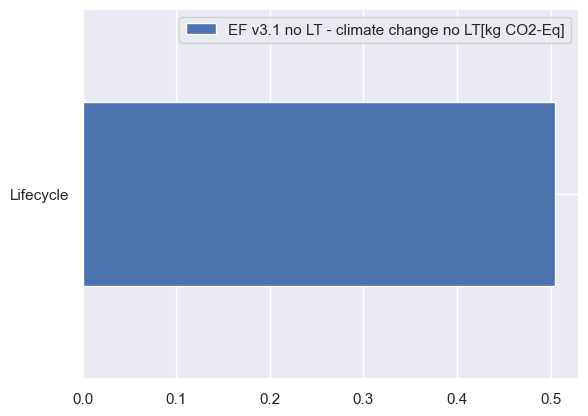

In [57]:
import seaborn as sns #for good-looking graph
sns.set() #seabron provide good looking display
sns.set_style('darkgrid')

df_impacts.plot.barh()

<div class="alert alert-block alert-danger">

**Question**

Isn't it a bit high for an EV driving 1 km in France ?   


To answer this question, let's compare it with a diesel vehicle

In [58]:
#find the activities that might correspond to diesel
[act for act in db_ei if 'diesel' in act['name'] and 'car' in act['name']]

['passenger car production, diesel' (kilogram, GLO, None),
 'market for passenger car, diesel' (kilogram, GLO, None),
 'transport, passenger, car, diesel, medium size, EURO 3' (kilometer, RoW, None),
 'transport, passenger, car, diesel, small size, EURO 4' (kilometer, RER, None),
 'transport, passenger, car, diesel, large size, EURO 4' (kilometer, RER, None),
 'transport, passenger, car, diesel, small size, EURO 5' (kilometer, RER, None),
 'market for transport, passenger, car, diesel, large size, EURO 3' (kilometer, GLO, None),
 'transport, passenger, car, diesel, small size, EURO 4' (kilometer, RoW, None),
 'market for transport, passenger, car, diesel, large size, EURO 5' (kilometer, GLO, None),
 'transport, passenger, car, diesel, large size, EURO 3' (kilometer, RER, None),
 'transport, passenger, car, diesel, medium size, EURO 4' (kilometer, RoW, None),
 'market for transport, passenger, car, diesel, medium size, EURO 3' (kilometer, GLO, None),
 'market for transport, passenger, c

In [59]:
#let's take one
lifecycle_diesel = agb.findActivity('transport, passenger, car, diesel, medium size, EURO 4', loc='RER', db_name='ecoinvent-3.11-cutoff')

Now let's compare both

[INFO] Db changed recently, clearing cache expr


<Axes: >

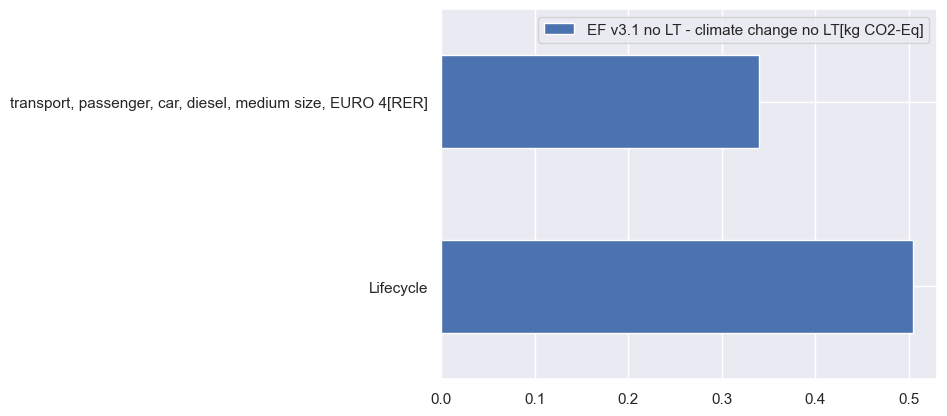

In [60]:
df_impacts = agb.compute_impacts([lifecycle_act, lifecycle_diesel], [CC])
df_impacts.plot.barh()

Something is wrong, we will look at it a bit later

## 3.4 Multi-impacts analysis

To evaluate the indicator results for the EV for several impact categories; the easiest way is to use the function ```compute_impacts``` with a list of impact categories

To get the whole list of impact cateogires of one calulcation method, le's say the [Environmental Footprint](https://green-business.ec.europa.eu/environmental-footprint-methods_en) method (named EF in Brightway) :

In [61]:
list_methods=agb.findMethods('EF v3.1 no LT')
list_methods

[('ecoinvent-3.11',
  'EF v3.1 no LT',
  'acidification no LT',
  'accumulated exceedance (AE) no LT'),
 ('ecoinvent-3.11',
  'EF v3.1 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'EF v3.1 no LT',
  'climate change: biogenic no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'EF v3.1 no LT',
  'climate change: fossil no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'EF v3.1 no LT',
  'climate change: land use and land use change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'EF v3.1 no LT',
  'ecotoxicity: freshwater no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('ecoinvent-3.11',
  'EF v3.1 no LT',
  'ecotoxicity: freshwater, inorganics no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('ecoinvent-3.11',
  'EF v3.1 no LT',
  'ecotoxicity: freshwater, organics no LT',
  'comparative toxic unit for ecosystems (CTUe

You just need to give the list methods to the function:

In [62]:
agb.compute_impacts(lifecycle_act, list_methods)

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
Lifecycle,0.00574435,0.504762,0.000672769,0.503844,0.000245172,1.47358,1.43045,0.0431316,6.4573,8.44003e-06,...,4.97774e-09,4.68456e-09,2.93177e-10,0.00413568,0.815954,9.24182e-06,7.63387e-09,1.61485e-08,0.00770081,0.0826489


**Back to [table of contents](#section0)?**
***

<a id='section4'></a>
# 4. Contribution analysis

To see how the impact is distributed along the lifecycle of an activity, we can do a contribution analysis.   

The sections below provide a panel of useful functions and nice plots.

## 4.1. 1 activity, 1 impact category

### 4.1.1. Identify the hotspots

In [63]:
import bw2analyzer as ba

One very useful method to quickly analyze the contribution tree of an activity in Brightway is the module ```.print_recursive_calculation()``` which is really easy-to-use:

In [64]:
ba.print_recursive_calculation?

Signature:
ba.print_recursive_calculation(
    activity,
    lcia_method,
    amount=1,
    max_level=3,
    cutoff=0.01,
    string_length=130,
    file_obj=None,
    tab_character='  ',
    use_matrix_values=False,
    _lca_obj=None,
    _total_score=None,
    __level=0,
    __first=True,
)
Docstring:
Traverse a supply chain graph, and calculate the LCA scores of each component. Prints the result with the format:

{tab_character * level }{fraction of total score} ({absolute LCA score for this input} | {amount of input}) {input activity}

Args:
    activity: ``Activity``. The starting point of the supply chain graph.
    lcia_method: tuple. LCIA method to use when traversing supply chain graph.
    amount: int. Amount of ``activity`` to assess.
    max_level: int. Maximum depth to traverse.
    cutoff: float. Fraction of total score to use as cutoff when deciding whether to traverse deeper.
    string_length: int. Maximum length of printed string.
    file_obj: File-like object (suppo

In [65]:
ba.print_recursive_calculation(lifecycle_act, CC, max_level=3,cutoff=0.1)

Fraction of score | Absolute score | Amount | Activity
0001 | 0,5048 |     1 | 'Lifecycle' (kilometer, GLO, None)
  0.147 | 0,07422 | 0,0075 | 'Production' (kilogram, GLO, None)
  0.844 | 0,4259 |     1 | 'Use' (kilometer, GLO, None)
    0.831 | 0,4193 |     4 | 'diesel, burned in diesel-electric generating set, 18.5kW' (megajoule, GLO, None)
      0.16 | 0,08077 | 0,0936 | 'market group for diesel' (kilogram, GLO, None)


### 4.1.2 Visualization

To get a prettier print, we first need to define an intermediate function for graph traversal :

In [66]:
# Extract contribution data
def get_contributions(activity, method, max_depth, cutoff=0.01, amount=1, labels=None, parents=None, values=None, levels=None, depth=1, total=None, **params):
    """extract the contribution of sub activities to the impact of the main activity.
    Returns lists that can directly be plotted as suburst or treemap.
    You can pass values of lca_algebraic parameters

    :param activity: main activity to plot contribution for
    :type activity: bw2 activity
    :param method: lcia method to compute impacts
    :type method: bw2 method
    :param max_depth: max recursion depth
    :type max_depth: int
    :param cutoff: minimum contribution proportion for an activity to be considered, defaults to 0.01
    :type cutoff: float, optional
    :param amount: recursion parameter, amount of exchange
    :type amount: float, optional
    :param labels: DO NOT CHANGE, recursion parameter, defaults to []
    :type labels: list, optional
    :param parents: DO NOT CHANGE, recursion parameter, defaults to []
    :type parents: list, optional
    :param values: DO NOT CHANGE, recursion parameter, defaults to []
    :type values: list, optional
    :param levels: DO NOT CHANGE, recursion parameter, defaults to []
    :type levels: list, optional
    :param depth: DO NOT CHANGE, recursion parameter, defaults to 1
    :type depth: int, optional
    :param total: DO NOT CHANGE, recursion parameter, defaults to None
    :type total: float, optional
    :return: tuple of labels, parents, values and levels for sunburst or treemap plot
    :rtype: tuple
    """
    
    if depth == 1:
        total = agb.compute_impacts(activity, [method], functional_unit=1/(amount), **params).iloc[0, 0] #impact of the main activity
        labels = []
        parents = []
        values = []
        levels = []
    
    for exc in activity.technosphere():
        input_activity = exc.input
        
        parent = activity['name']
        label = input_activity['name']
        value = agb.compute_impacts(input_activity, [method], functional_unit=1/(amount*exc.amount), **params).iloc[0, 0]
        
        if value > cutoff*total: #get only the most contributing activities
        
            parents.append(parent)
            values.append(value)
            labels.append(label)
            levels.append(depth)
            
            # Recursively get contributions from child activities
            if depth < max_depth:
                get_contributions(input_activity, method, max_depth, cutoff,amount*exc.amount, labels, parents, values, levels, depth+1, total, **params)
                
    return labels, parents, values, levels


Get the contributions of whole lifecycle, for climate change

In [67]:
labels, parents, values, levels = get_contributions(lifecycle_act, CC, 3, 0.01)

plot a Sunburst

In [68]:
import plotly.graph_objects as go

fig = go.Figure(go.Sunburst(
        labels=labels,
        parents=parents,
        values=values, 
        branchvalues="total",
    )) 

fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

or a Treemap

In [69]:
fig = go.Figure(go.Treemap(
        labels=labels,
        parents=parents,
        values=values,
        branchvalues="total",
    )) 

fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

/!\ You may have plot problems if different activities have the same activity in input (ex : battery production and use both consume electricity). In that case, play with cutoff and max_depth to avoid this problem

## 4.2. N activities, 1 impact category

The method above enables a very detailed analysis of one activity. Now suppose we want to compare several activities and their first-level contributors at the same time

In [70]:
#example with 2 battery chemistries, see what is available :
[act for act in db_ei if 'battery production' in act['name']]

['battery production, lead acid, rechargeable, stationary' (kilogram, US, None),
 'battery production, Li-ion, NCA, rechargeable' (kilogram, RoW, None),
 'battery production, Li-ion, LFP, rechargeable' (kilogram, CN, None),
 'battery production, Li-ion, NMC111, rechargeable' (kilogram, RoW, None),
 'battery production, lead acid, rechargeable, stationary' (kilogram, RoW, None),
 'battery production, Li-ion, NMC811, rechargeable' (kilogram, CN, None),
 'battery production, Li-ion, LiMn2O4, rechargeable' (kilogram, GLO, None),
 'battery production, Li-ion, NMC532, rechargeable' (kilogram, CN, None),
 'battery production, Na-NiCl, rechargeable' (kilogram, CH, None),
 'battery production, NiMH, rechargeable' (kilogram, GLO, None),
 'battery production, Li-ion, NMC811, rechargeable' (kilogram, RoW, None),
 'battery production, Li-ion, NCA, rechargeable' (kilogram, CN, None),
 'battery production, Li-ion, LFP, rechargeable' (kilogram, RoW, None),
 'battery production, Li-ion, NMC532, recharg

In [71]:
#select the two we want to see
battery_nmc = agb.findActivity('battery production, Li-ion, NMC811, rechargeable', loc='CN', db_name='ecoinvent-3.11-cutoff')
battery_lfp = agb.findActivity('battery production, Li-ion, LFP, rechargeable', loc='CN', db_name='ecoinvent-3.11-cutoff')

activities = [battery_nmc,battery_lfp]

Make use of the function described above, with max_depth set to 1 :

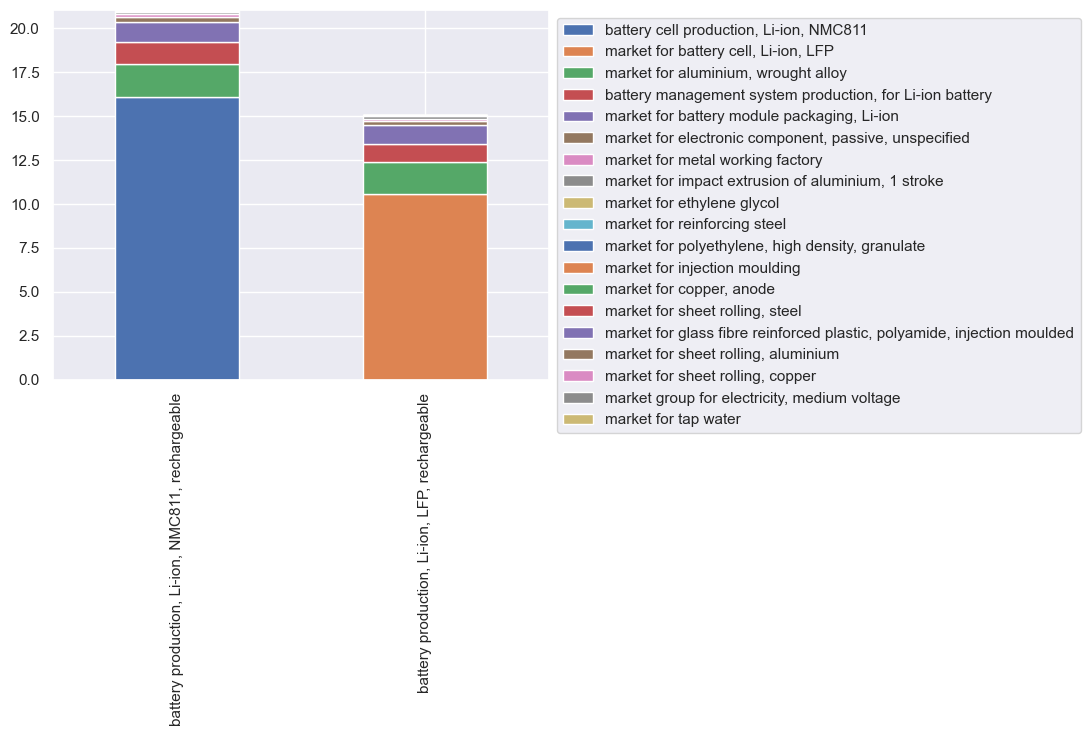

In [72]:
list_dfs = [] #initialize the list of results

for activity in activities: #first level contribution analysis of every activity
    labels, parents, values, levels = get_contributions(activity, CC, 1, 0.0) #you can change the cutoff value
    list_dfs.append(pd.DataFrame({activity['name'] : values}, index=labels))

df_impacts = pd.concat(list_dfs, axis=1) #aggregate results

# Sort the DataFrame by the ascending sum of columns
sorted_df = df_impacts.loc[df_impacts.sum(axis=1).sort_values(ascending=False).index]

#plot
ax = sorted_df.T.plot.bar(stacked=True) 
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')


## 4.3. 1 activity, N impact categories

A way to visualize the contribution for several impact categories in one plot is to use stacked bar chart. To help with this, we can use the code above and loop over several impact categories. What we will do here is more flexible. We will make use of another lca_algebraic functionnality : agb.compute_impacts(activity, methods, axis = 'phase')

For this, we need to find the relevant activities, and assign them with a custom attribute : 'phase'

In [73]:
#find relevant activities in the foreground database
battery_prod_act = agb.findActivity('battery production, Li-ion, NMC811, rechargeable', db_name='tuto_EV-code')
glider_prod_act = agb.findActivity('glider production, passenger car', db_name='tuto_EV-code')
powertrain_prod_act = agb.findActivity('powertrain production, for electric passenger car', db_name='tuto_EV-code')
use_act = agb.findActivity('Use', db_name='tuto_EV-code')
eol_act = agb.findActivity('End of Life', db_name='tuto_EV-code')

#assign them a custom attribute
battery_prod_act.updateMeta(phase = 'Prod - battery')
glider_prod_act.updateMeta(phase = 'Prod - other')
powertrain_prod_act.updateMeta(phase = 'Prod - other') #you can assign the same name for several activities, their contributions will be added
use_act.updateMeta(phase = 'Use')
eol_act.updateMeta(phase = 'EoL')

#see what has changed
use_act.as_dict()

{'comment': 'Use phase of electric vehicle, including electricity consumption and maintenance',
 'location': 'GLO',
 'reference product': 'Use',
 'type': 'processwithreferenceproduct',
 'unit': 'kilometer',
 'name': 'Use',
 'worksheet name': 'example_EV',
 'database': 'tuto_EV-code',
 'code': '1bdffe9dc7c4894a8e26a43df916c612',
 'id': 239796640791920640,
 'phase': 'Use'}

Note that here we do the contribution analysis with the first level input activities, but the power and flexibility of this methods is that you can assign a custom attribute and see the contribution of any activity, independent on its level in the supply chain (as long as it is in the foreground database).

In [75]:
#compute impacts
df_impacts = agb.compute_impacts(lifecycle_act, list_methods, axis = 'phase')
df_impacts

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
phase,,,,,,,,,,,,,,,,,,,,,
EoL,1.8364e-05,0.00460872,0.000162334,0.0044438,2.58377e-06,0.0394357,0.0391911,0.000244563,0.018264,7.21118e-08,...,1.07884e-10,1.05661e-10,2.22358e-12,5.95903e-05,0.00720573,3.85104e-08,1.261e-11,1.02013e-10,7.53947e-06,0.00096846
Prod_battery,0.000390858,0.0336888,7.70744e-05,0.0335543,5.73913e-05,0.404175,0.399826,0.0043496,0.436399,2.31366e-06,...,1.89105e-09,1.78588e-09,1.05171e-10,0.00151375,0.182989,3.69494e-06,5.14974e-10,3.00117e-09,0.000152762,0.0454705
Prod_other,0.000289722,0.0405296,5.60628e-05,0.0404067,6.68587e-05,0.526547,0.514241,0.0123062,0.531071,3.18285e-06,...,1.36931e-09,1.2985e-09,7.08058e-11,0.00128621,0.187092,3.8546e-06,9.0692e-10,3.03632e-09,0.000190797,0.0154151
Use,0.0050454,0.425935,0.000377298,0.425439,0.000118338,0.503423,0.477192,0.0262312,5.47157,2.8714e-06,...,1.60949e-09,1.49451e-09,1.14977e-10,0.00127613,0.438667,1.65378e-06,6.19937e-09,1.0009e-08,0.00734971,0.0207948
_other_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*sum*,0.00574435,0.504762,0.000672769,0.503844,0.000245172,1.47358,1.43045,0.0431316,6.4573,8.44003e-06,...,4.97774e-09,4.68456e-09,2.93177e-10,0.00413568,0.815954,9.24182e-06,7.63387e-09,1.61485e-08,0.00770081,0.0826489


Now, reorder the lines to be more coherent, and plot this, normalized with total impact

<Axes: xlabel='normalized impact'>

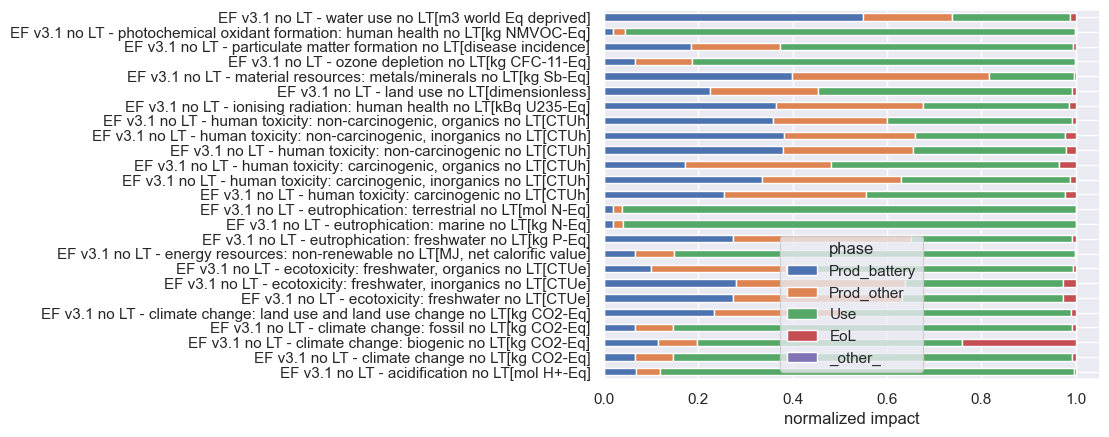

In [76]:
#reorder lines
df_impacts = df_impacts.loc[['Prod_battery','Prod_other','Use','EoL','_other_','*sum*']]
#Rq : df_impacts = df_impacts.iloc[[1,2,3,0,4,5]] does the same thing

#normalize by the sum
df_normalized = (df_impacts.iloc[:-1]/df_impacts.iloc[-1]).T

#plot
df_normalized.plot.barh(stacked=True, xlabel='normalized impact')
#To move the legend : plt.legend(loc='lower center')

<a id='section5'></a>
# 5. Edit Model & Parametrization

Since the model provided has errors, we need to modify the activities it contains.

## 5.1 Delete exchanges

First, we will delete the activity identified previously that leads to overestimated LCA impacts. To do so, again, we will use the functions from ```lca_algebraic``` to update the activities and their exchanges

In [77]:
lifecycle_act.deleteExchanges??

Signature: lifecycle_act.deleteExchanges(name, single=True)
Source:   
    def deleteExchanges(self, name, single=True):
        """Remove matching exchanges

        Parameters
        ----------
        name:
            Name of the exchange to delete. Can contain wildcards. See #getExchange for more details.

        single:
            If true (default) expect to only delete a single exchange
        """
        exchs = self.getExchange(name, single=single)
        if not isinstance(exchs, list):
            exchs = [exchs]
        if len(exchs) == 0:
            raise Exception("No exchange found for '%s'" % name)
        for ex in exchs:
            ex.delete()
            ex.save()
        self.save()
File:      c:\users\vm256232\appdata\local\miniforge3\envs\bw25\lib\site-packages\lca_algebraic\activity.py
Type:      method

In [78]:
use_act.deleteExchanges('diesel, burned in diesel-electric generating set, 18.5kW')
agb.printAct(use_act)

Use (1.000000 kilometer)  \
                                                                                                input   
maintenance, passenger car, electric, without b...  maintenance, passenger car, electric, without ...   

                                                                     
                                                       amount  unit  
maintenance, passenger car, electric, without b... 6.6667e-06  unit

We have remove the wrong exchange and updated successfully our activity

## 5.2 Add exchanges

There is no electricity in Use

In [79]:
# search for it in ecoinvent
[act for act in db_ei if 'electricity, low voltage' in act['name'] and 'FR' in act['location']]

['electricity, low voltage, residual mix' (kilowatt hour, FR, None),
 'market for electricity, low voltage' (kilowatt hour, FR, None)]

In [80]:
elec_act = agb.findActivity('market for electricity, low voltage', loc='FR', db_name = 'ecoinvent-3.11-cutoff')
agb.printAct(elec_act)

market for electricity, low voltage[FR] (1.000000 kilowatt hour)  \
                                                                                                          input   
Sulfur hexafluoride                                                           Sulfur hexafluoride                 
distribution network, electricity, low voltage  market for distribution network, electricity, ...                 
electricity, low voltage                        electricity production, photovoltaic, 570kWp o...                 
electricity, low voltage#1                      electricity voltage transformation from medium...                 
electricity, low voltage#2                      electricity production, photovoltaic, 3kWp sla...                 
electricity, low voltage#3                                market for electricity, low voltage[FR]                 
electricity, low voltage#4                      electricity production, photovoltaic, 3kWp sla...                 
sulfur hexafluoride, liquid                           market for sulfur hexafluoride, liquid[RER]                 

                                                                           
                                                    amount           unit  
Sulfur hexafluoride                               4.03e-10       kilogram  
distribution network, electricity, low voltage 8.74049e-08      kilometer  
electricity, low voltage                         0.0132134  kilowatt hour  
electricity, low voltage#1                        0.948586  kilowatt hour  
electricity, low voltage#2                       0.0211754  kilowatt hour  
electricity, low voltage#3                       0.0314778  kilowatt hour  
electricity, low voltage#4                        0.017025  kilowatt hour  
sulfur hexafluoride, liquid                       4.03e-10       kilogram

In [81]:
# Update exchanges by their name 
use_act.addExchanges({
    elec_act : 0.163
}) 

In [82]:
agb.printAct(use_act)

Use (1.000000 kilometer)  \
                                                                                                input   
maintenance, passenger car, electric, without b...  maintenance, passenger car, electric, without ...   
market for electricity, low voltage                           market for electricity, low voltage[FR]   

                                                                              
                                                       amount           unit  
maintenance, passenger car, electric, without b... 6.6667e-06           unit  
market for electricity, low voltage                     0.163  kilowatt hour

Now, if you want, you can execute again the code for contribution analysis, and see what has changed

## 5.3 Add formulas

Parametrization is really useful to adress the variability in LCAs. It consists simply in replacing static amount (ex: 1271 kg production of seeds + cotton) by a formulas that depends on variable parameters that has their own distribution (ex: $production_{cotton} = \lambda * 2 +5$ where $\lambda$ is a normal distribution)

This makes possible to compute a range and even a distrbution of LCA results

### Symbolic calculus

```lca_algebraic``` has been specifically designed to handle parametrization in LCA using a **symbolic expression that can be manipulated**, instead of a **numeric value**.

In [83]:
from sympy import symbols 

# create sympy symbol
a = symbols("a")

# Expressions are not directly evaluated 
f = a * 2 + 4 
f

2*a + 4

In [84]:
# symbols can be replaced by values afterwards 
f.subs(dict(a=3))

10

### Define input parameters

Before implementing parameters, this is better to clean up the whole foreground model each time.  
Any persistent state is prone to errors.

In [85]:
agb.resetParams()

We start with a parameter to model the electricity consumption of the vehicle, named "efficiency", in kWh/km

In [86]:
# Example of 'float' parameters
efficiency = agb.newFloatParam( #there are several type of parameters (Float, Discrete, Enum, Boolean...) check the documentation to know more
    name = 'efficiency', #name of the parameter. I recommend writing the same name as the variable, to avoid any confusion
    default=0.163, min=0.1, max=0.2,  distrib=agb.DistributionType.TRIANGLE, # Distribution type, triangle by default but many exists (Normal, Lognormal...)
    unit='kWh/km',
    description="electricity consumption of the car, in kWh/km",
    dbname='tuto_EV-code' #if no database is given, the parameter is linked to the whole project instead of a specific database
    )

Create the other parameters (values and distribution are dummy)

In [87]:
mass_EV = agb.newFloatParam( #there are several type of parameters (Float, Discrete, Enum, Boolean...) check the documentation to know more
    name = 'mass_EV', #name of the parameter
    default=1500, min=1000, max=2000,  distrib=agb.DistributionType.TRIANGLE, # Dummy values
    unit='kg',
    description='mass of the vehicle',
    dbname='tuto_EV-code'
    )

total_distance = agb.newFloatParam( #there are several type of parameters (Float, Discrete, Enum, Boolean...) check the documentation to know more
    name = 'total_distance', #name of the parameter
    default=200000, min=100000, max=400000,  distrib=agb.DistributionType.TRIANGLE, # Dummy values
    unit='km',
    description='distance driven by the vehicle during its whole lifecycle',
    dbname='tuto_EV-code'
    )

passenger_number = agb.newFloatParam( #there are several type of parameters (Float, Discrete, Enum, Boolean...) check the documentation to know more
    name = 'passenger_number', #name of the parameter
    default=2, min=1, max=4, distrib=agb.DistributionType.TRIANGLE, # Dummy values
    unit='',
    description='number of passengers inside the car',
    dbname='tuto_EV-code'
    )


To see the list of parameters, almost the same command as for the databases:

In [88]:
agb.list_parameters()

group,name,label,default,min,max,std,distrib,unit,db
,efficiency,efficiency,0.163,0.1,0.2,,triangle,kWh/km,tuto_EV-code
,mass_EV,mass EV,1500,1000,2000,,triangle,kg,tuto_EV-code
,passenger_number,passenger number,2,1,4,,triangle,,tuto_EV-code
,total_distance,total distance,200000,100000,400000,,triangle,km,tuto_EV-code


### Parameterize the inventory

Firstly, we need to update the final production in the lifecycle activity with the mass of the vehicle and total distance parameters

In [89]:
lifecycle_act.updateExchanges({ # 1 kilometer
    "Production": mass_EV/total_distance,
    "End of Life": -mass_EV/total_distance
})

In [90]:
agb.printAct(lifecycle_act)

Lifecycle (1.000000 kilometer)                                    
                                     input                   amount       unit
End of Life                End of Life{FG}  -mass_EV/total_distance   kilogram
Production                  Production{FG}   mass_EV/total_distance   kilogram
Use                                Use{FG}                        1  kilometer

Now, we will update the use phase:

In [91]:
agb.printAct(use_act)

Use (1.000000 kilometer)  \
                                                                                                input   
maintenance, passenger car, electric, without b...  maintenance, passenger car, electric, without ...   
market for electricity, low voltage                           market for electricity, low voltage[FR]   

                                                                              
                                                       amount           unit  
maintenance, passenger car, electric, without b... 6.6667e-06           unit  
market for electricity, low voltage                     0.163  kilowatt hour

Here the electricity mix is the french one, but we want also to parametrize this. First we create a new parameter

In [92]:
elec_mix = agb.newEnumParam( #we define a Enum parameters, that can take discrete values
    name = 'elec_mix', #name of the parameter
    default='FR', values = ['FR','US','CN'], #the values this parameter can take
    unit='',
    description='location of the electricity mix used',
    dbname='tuto_EV-code'
    )

Then we create a new activity based on this parameter

In [93]:
fr_elec = [act for act in bd.Database("ecoinvent-3.11-cutoff") if "market for electricity, low voltage" in act['name'] and 'FR' in act['location']][0]
eu_elec = [act for act in bd.Database("ecoinvent-3.11-cutoff") if "market group for electricity, low voltage" in act['name'] and 'ENTSO-E' in act['location']][0]
us_elec = [act for act in bd.Database("ecoinvent-3.11-cutoff") if "market group for electricity, low voltage" in act['name'] and 'US' in act['location']][0]
cn_elec = [act for act in bd.Database("ecoinvent-3.11-cutoff") if "market group for electricity, low voltage" in act['name'] and 'CN' in act['location']][0]
glo_elec = [act for act in bd.Database("ecoinvent-3.11-cutoff") if "market group for electricity, low voltage" in act['name'] and 'GLO' in act['location']][0]

In [94]:
# get the activities corresponding to the different locations
fr_elec = agb.findActivity('market for electricity, low voltage', loc='FR', db_name="ecoinvent-3.11-cutoff")
eu_elec = agb.findActivity('market group for electricity, low voltage', loc='US', db_name="ecoinvent-3.11-cutoff")
cn_elec = agb.findActivity('market group for electricity, low voltage', loc='CN', db_name="ecoinvent-3.11-cutoff")

# create a new switch activity
elec_switch_act = agb.newSwitchAct('tuto_EV-code','electricity',
                                   elec_mix,
                                   {
                                       'FR' : fr_elec,
                                       'US' : us_elec,
                                       'CN' : cn_elec,
                                   })

Remove the static exchange and add the new one

In [95]:
use_act.deleteExchanges("market for electricity, low voltage")
use_act.addExchanges({
    elec_switch_act : efficiency #we parametrize also the amount of the exchange
})

In [96]:
agb.printAct(use_act)

Use (1.000000 kilometer)  \
                                                                                                input   
electricity                                                                           electricity{FG}   
maintenance, passenger car, electric, without b...  maintenance, passenger car, electric, without ...   

                                                                               
                                                        amount           unit  
electricity                                         efficiency  kilowatt hour  
maintenance, passenger car, electric, without b...  6.6667e-06           unit

Now our inventory is parameterized and ready to be assessed !

# 6. Defining scenarios

Modify manually parameters, export results and compare them can be very fastidious if you have lots of parameters and scenarios. A way to be more efficient is to use Scenarios.

Scenarios are a set of values for each parameters. 
In Brightway, you just need to specify the parameter value when computing the impacts

<div class="alert alert-block alert-danger">

Let's **compare the following scenarios**:

1. lighter vehicle
2. Use in China
3. 300 000 km , 2 persons in the car instead of one
4. Whatever you want

**QUESTION** = Which scenario has the lower impacts ?

## 6.0 Scenario 0 

First lets compute the impacts with the referecne values

In [97]:
scenario0 = agb.compute_impacts(lifecycle_act,list_methods)
scenario0

[INFO] Db changed recently, clearing cache expr
INFO	Task(Task-3) lca_algebraic:cache.py:__init__()- Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia
INFO	Task(Task-3) lca_algebraic:cache.py:__init__()- Db changed recently, clearing cache lcia
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-154_0) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-154_1) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-154_2) 

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
Lifecycle,0.000835449,0.0997959,0.000329043,0.099317,0.000149833,1.09,1.07156,0.0184377,2.98352,6.44308e-06,...,4.04216e-09,3.82708e-09,2.15086e-10,0.021714,0.502014,8.33517e-06,1.95118e-09,7.00629e-09,0.000862996,0.0878409


## 6.1 Scenario 1

**Scenario 1** means we want to compare our Renault tech E5 with a lighter vehicle : BMW i3, with mass 1300 kg and efficiency 130 Wh/km

In [98]:
agb.printAct(lifecycle_act, mass_EV=1300, efficiency=0.130)

Lifecycle (1.000000 kilometer)                                 
                                     input                amount       unit
End of Life                End of Life{FG}  -1300/total_distance   kilogram
Production                  Production{FG}   1300/total_distance   kilogram
Use                                Use{FG}                     1  kilometer

In [99]:
agb.printAct(use_act, mass_EV=1300, efficiency=0.130)

Use (1.000000 kilometer)  \
                                                                                                input   
electricity                                                                           electricity{FG}   
maintenance, passenger car, electric, without b...  maintenance, passenger car, electric, without ...   

                                                                       \
                                                               amount   
electricity                                         0.130000000000000   
maintenance, passenger car, electric, without b...         6.6667e-06   

                                                                   
                                                             unit  
electricity                                         kilowatt hour  
maintenance, passenger car, electric, without b...           unit

In [100]:
scenario1 = agb.compute_impacts(lifecycle_act, list_methods, mass_EV=1300, efficiency=0.130)
scenario1

[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-155_0) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-155_1) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-155_2) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-155_3) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
Lifecycle,0.000720347,0.0863823,0.000284393,0.085968,0.000129969,0.943263,0.927256,0.0160071,2.47286,5.57164e-06,...,3.4699e-09,3.28525e-09,1.84651e-10,0.0175589,0.430279,7.18327e-06,1.67849e-09,6.07933e-09,0.000804796,0.0747912


## 6.2 Scenario 2

**Scenario 2** means we want the electricity mix used during the use phase to be the chinese one

In [101]:
agb.printAct(elec_switch_act, elec_mix='CN')

electricity (1.000000 kilowatt hour)  \
                                                                                     input   
market for electricity, low voltage                market for electricity, low voltage[FR]   
market group for electricity, low voltage    market group for electricity, low voltage[US]   
market group for electricity, low voltage#1  market group for electricity, low voltage[CN]   

                                                                              
                                                       amount           unit  
market for electricity, low voltage                       0.0  kilowatt hour  
market group for electricity, low voltage                 0.0  kilowatt hour  
market group for electricity, low voltage#1  1.00000000000000  kilowatt hour

In [102]:
scenario2 = agb.compute_impacts(lifecycle_act, list_methods, elec_mix='CN')
scenario2

[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-156_0) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-156_1) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
[INFO] Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-156_2) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200000
INFO	Thread(ThreadPoolExecutor-156_3) lca_algebraic:params.py:_complete_params()- Required param 'total_distance' was missing, replacing by default value : 200

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
Lifecycle,0.00157419,0.224719,0.000327831,0.224195,0.000195974,1.44653,1.42714,0.0193938,2.60036,8.90192e-06,...,4.66864e-09,4.44114e-09,2.27504e-10,0.00523727,0.755909,8.30851e-06,1.92554e-09,1.79087e-08,0.00129554,0.0830475


## 6.3 Scenario 3

Scenario 3 = 300000 km, 2 persons in the car instead of 1.

300 000 km :

In [103]:
agb.printAct(lifecycle_act, total_distance=300000)

Lifecycle (1.000000 kilometer)                            
                                     input           amount       unit
End of Life                End of Life{FG}  -mass_EV/300000   kilogram
Production                  Production{FG}   mass_EV/300000   kilogram
Use                                Use{FG}                1  kilometer

To see the effect of having 2 persons in the car instead of 1, we can change the functional unit of the activity. It was impacts/km, now we can divide also by the number of persons in the car, here is how we do that

In [104]:
scenario3 = agb.compute_impacts(lifecycle_act, list_methods, functional_unit = passenger_number, passenger_number = 2, total_distance = 300000)
scenario3

[INFO] Required param 'mass_EV' was missing, replacing by default value : 1500
INFO	Thread(ThreadPoolExecutor-157_0) lca_algebraic:params.py:_complete_params()- Required param 'mass_EV' was missing, replacing by default value : 1500
[INFO] Required param 'mass_EV' was missing, replacing by default value : 1500
[INFO] Required param 'mass_EV' was missing, replacing by default value : 1500
INFO	Thread(ThreadPoolExecutor-157_1) lca_algebraic:params.py:_complete_params()- Required param 'mass_EV' was missing, replacing by default value : 1500
[INFO] Required param 'mass_EV' was missing, replacing by default value : 1500
INFO	Thread(ThreadPoolExecutor-157_2) lca_algebraic:params.py:_complete_params()- Required param 'mass_EV' was missing, replacing by default value : 1500
[INFO] Required param 'mass_EV' was missing, replacing by default value : 1500
INFO	Thread(ThreadPoolExecutor-157_3) lca_algebraic:params.py:_complete_params()- Required param 'mass_EV' was missing, replacing by default va

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
Lifecycle,0.000301234,0.0367601,0.000115276,0.036591,5.37775e-05,0.383305,0.376903,0.0064021,1.32747,2.29344e-06,...,1.45971e-09,1.38186e-09,7.78432e-11,0.0103804,0.188126,2.90291e-06,7.36504e-10,2.47989e-09,0.000372981,0.0336114


## 6.4 PostTreatment: visualization to compare scenarios

To compare scenario results, we will build nice visualization using ```pandas``` package for generating nice Tables (so-called Dataframe) and ```seabron``` package with ```matplotlib``` package for plotting nice graphs with pretty colors

Let's gather all results in one unique Dataframe:

In [105]:
df_results_scenarios = pd.concat(
    [scenario0, scenario1, scenario2, scenario3],
    ignore_index=True
)
df_results_scenarios

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
0,0.000835449,0.0997959,0.000329043,0.099317,0.000149833,1.09,1.07156,0.0184377,2.98352,6.44308e-06,...,4.04216e-09,3.82708e-09,2.15086e-10,0.021714,0.502014,8.33517e-06,1.95118e-09,7.00629e-09,0.000862996,0.0878409
1,0.000720347,0.0863823,0.000284393,0.085968,0.000129969,0.943263,0.927256,0.0160071,2.47286,5.57164e-06,...,3.4699e-09,3.28525e-09,1.84651e-10,0.0175589,0.430279,7.18327e-06,1.67849e-09,6.07933e-09,0.000804796,0.0747912
2,0.00157419,0.224719,0.000327831,0.224195,0.000195974,1.44653,1.42714,0.0193938,2.60036,8.90192e-06,...,4.66864e-09,4.44114e-09,2.27504e-10,0.00523727,0.755909,8.30851e-06,1.92554e-09,1.79087e-08,0.00129554,0.0830475
3,0.000301234,0.0367601,0.000115276,0.036591,5.37775e-05,0.383305,0.376903,0.0064021,1.32747,2.29344e-06,...,1.45971e-09,1.38186e-09,7.78432e-11,0.0103804,0.188126,2.90291e-06,7.36504e-10,2.47989e-09,0.000372981,0.0336114


To plot all impact categories, one interesting solution is in heatmaps, by comparing the relative increase compared to one reference activity in each impact categories. Here is the syntax

In [106]:
#we normalize by the results of the reference activity
df_norm = (df_results_scenarios / df_results_scenarios.loc[0]) #normalizaton with the results from the activity wind
df_norm

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0.862228,0.86559,0.864304,0.865591,0.867426,0.865382,0.865334,0.868173,0.828841,0.864748,...,0.858427,0.858423,0.858497,0.808644,0.857107,0.861802,0.860245,0.867696,0.932561,0.85144
2,1.88425,2.25178,0.996316,2.25737,1.30795,1.3271,1.33184,1.05186,0.871576,1.38163,...,1.15499,1.16045,1.05773,0.241194,1.50575,0.996801,0.986859,2.55609,1.50121,0.94543
3,0.360565,0.368353,0.350338,0.368427,0.358917,0.351657,0.351733,0.347229,0.444934,0.355953,...,0.36112,0.361076,0.361916,0.478051,0.374742,0.348273,0.377467,0.353953,0.432194,0.38264


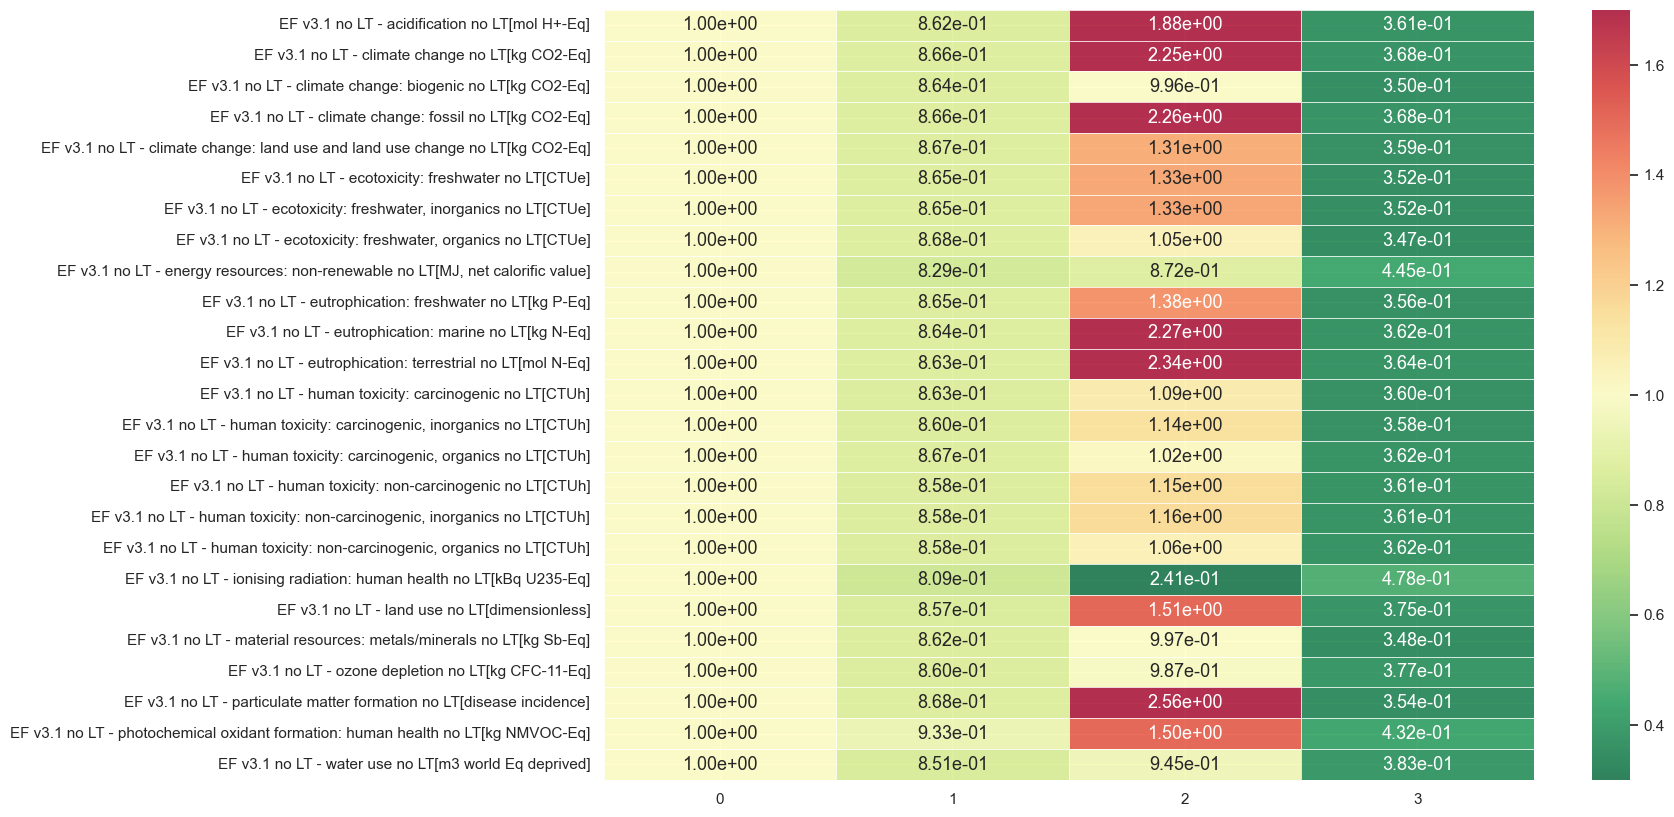

In [107]:
fig, axes = plt.subplots(figsize=(15,10))
sns.set_style("darkgrid")
sns.heatmap(
    df_norm.T, 
    annot=True, #display numerical values
    cbar=True, #color bar appears
    ax=axes, 
    cmap='RdYlGn_r', #green for small values, red for higher
    alpha=0.8, 
    linewidth=0.5, 
    xticklabels=True,
    fmt=".2e",  # Format numbers with two decimal places
    annot_kws={"size": 13},  # Adjust font size for annotations,
    vmin=0.3, vmax=1.7 #to set the color scale
)

# plt.savefig("./outputs/" + "heatmap_example.png", dpi=600) #to save the plot
plt.show()

another way is a bar plot (maybe too many categories here)

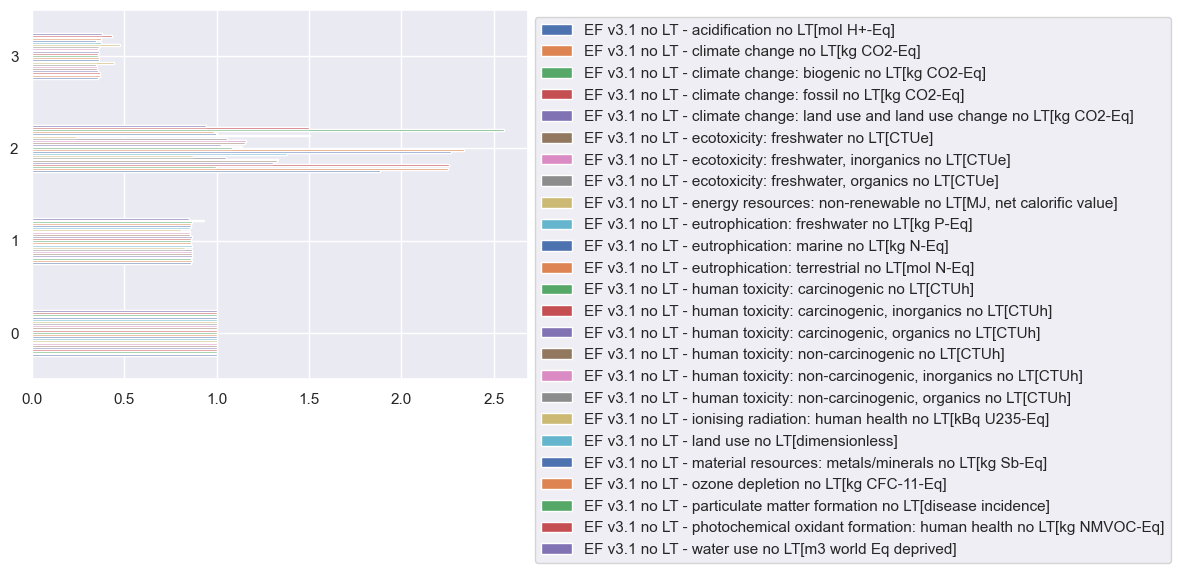

In [108]:
ax = df_norm.plot.barh()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

## 6.5 Exercise

1) Create a new parameter, "chemistry", that can take 2 values : "LFP" or "NMC811". The default in our model is NMC811.
2) Copy the ecoinvent activity for LFP battery into our foreground database (you can search on the internet for this function)
3) Create a new switch activity that can point to either battery technology, depending on the chemistry parameter value
4) Link this activity to our model
5) Make a scenario analysis with a nice plot

# 7. Variation analysis

## 7.1. Influence of foreground parameters : sensitivity analysis

### 1 parameter, 1 impact category, with contribution analysis

Now, we will assess the impact of total distance on the GWP of the car, per km. Again, we make use of the "axis" functionality of compute_impacts.

In [109]:
Total_distances = np.linspace(1e5,1e6,10) #set the range of the parameter we want to compute

list_dfs = [] #initialize results

for d in Total_distances: #loop over the total_distances
    res = agb.compute_impacts(lifecycle_act,[CC],axis='phase',total_distance=d) #compute the impacts, per phase, for given total_distance d
    list_dfs.append(res) #save in the list

df_impacts = pd.concat(list_dfs, axis=1) #concatenate
df_impacts.columns = Total_distances #rename the columns with the distance value
df_impacts

c:\Users\VM256232\AppData\Local\miniforge3\envs\bw25\Lib\site-packages\lca_algebraic\lca.py:945: SymPyDeprecationWarning:



non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.


c:\Users\VM256232\AppData\Local\miniforge3\envs\bw25\Lib\site-packages\sympy\polys\domains\expressionrawdomain.py:54: SymPyDeprecationWarning:



Using non-Expr arguments in Add is deprecated (in this case, one of
the arguments has type 'AxisDict').

If you really did intend to use a multiplication or addition operation with
this object, use the * or + operator instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.

,"100,000","200,000","300,000","400,000","500,000","600,000","700,000","800,000","900,000",1e+06
phase,,,,,,,,,,
EoL,0.00921744,0.00460872,0.00307248,0.00230436,0.00184349,0.00153624,0.00131678,0.00115218,0.00102416,0.000921744
Prod_battery,0.0673775,0.0336888,0.0224592,0.0168444,0.0134755,0.0112296,0.00962536,0.00842219,0.00748639,0.00673775
Prod_other,0.0810593,0.0405296,0.0270198,0.0202648,0.0162119,0.0135099,0.0115799,0.0101324,0.00900659,0.00810593
Use,0.0209688,0.0209688,0.0209688,0.0209688,0.0209688,0.0209688,0.0209688,0.0209688,0.0209688,0.0209688
_other_,0,0,0,0,0,0,0,0,0,0
*sum*,0.178623,0.0997959,0.0735202,0.0603823,0.0524996,0.0472445,0.0434908,0.0406756,0.0384859,0.0367342


Reorganize and plot

Text(0, 0.5, 'GWP [kgCO2-eq / km]')

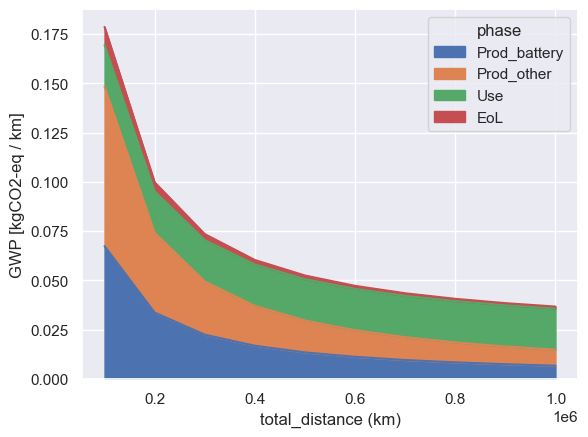

In [110]:
df_impacts = df_impacts.iloc[[1,2,3,0]] #select and reorder the lines we want to plot

ax = df_impacts.T.plot.area() #plot an stacked area chart
ax.set_xlabel('total_distance (km)')
ax.set_ylabel('GWP [kgCO2-eq / km]')

### 1 parameter, N impact categories

We can directly provide a list of parameters values in compute_impacts

In [111]:
df_impacts = agb.compute_impacts(lifecycle_act,list_methods,total_distance=Total_distances)
df_impacts.index = Total_distances #reindex to store total_distance values
df_impacts

[INFO] Required param 'efficiency' was missing, replacing by default value : 0.163
INFO	Thread(ThreadPoolExecutor-168_0) lca_algebraic:params.py:_complete_params()- Required param 'efficiency' was missing, replacing by default value : 0.163
[INFO] Required param 'efficiency' was missing, replacing by default value : 0.163
[INFO] Required param 'efficiency' was missing, replacing by default value : 0.163
INFO	Thread(ThreadPoolExecutor-168_1) lca_algebraic:params.py:_complete_params()- Required param 'efficiency' was missing, replacing by default value : 0.163
[INFO] Required param 'efficiency' was missing, replacing by default value : 0.163
INFO	Thread(ThreadPoolExecutor-168_2) lca_algebraic:params.py:_complete_params()- Required param 'efficiency' was missing, replacing by default value : 0.163
[INFO] Required param 'efficiency' was missing, replacing by default value : 0.163
INFO	Thread(ThreadPoolExecutor-168_3) lca_algebraic:params.py:_complete_params()- Required param 'efficiency' w

,EF v3.1 no LT - acidification no LT[mol H+-Eq],EF v3.1 no LT - climate change no LT[kg CO2-Eq],EF v3.1 no LT - climate change: biogenic no LT[kg CO2-Eq],EF v3.1 no LT - climate change: fossil no LT[kg CO2-Eq],EF v3.1 no LT - climate change: land use and land use change no LT[kg CO2-Eq],EF v3.1 no LT - ecotoxicity: freshwater no LT[CTUe],"EF v3.1 no LT - ecotoxicity: freshwater, inorganics no LT[CTUe]","EF v3.1 no LT - ecotoxicity: freshwater, organics no LT[CTUe]","EF v3.1 no LT - energy resources: non-renewable no LT[MJ, net calorific value]",EF v3.1 no LT - eutrophication: freshwater no LT[kg P-Eq],...,EF v3.1 no LT - human toxicity: non-carcinogenic no LT[CTUh],"EF v3.1 no LT - human toxicity: non-carcinogenic, inorganics no LT[CTUh]","EF v3.1 no LT - human toxicity: non-carcinogenic, organics no LT[CTUh]",EF v3.1 no LT - ionising radiation: human health no LT[kBq U235-Eq],EF v3.1 no LT - land use no LT[dimensionless],EF v3.1 no LT - material resources: metals/minerals no LT[kg Sb-Eq],EF v3.1 no LT - ozone depletion no LT[kg CFC-11-Eq],EF v3.1 no LT - particulate matter formation no LT[disease incidence],EF v3.1 no LT - photochemical oxidant formation: human health no LT[kg NMVOC-Eq],EF v3.1 no LT - water use no LT[m3 world Eq deprived]
"100,000",0.00153439,0.178623,0.000624514,0.177722,0.000276667,2.06015,2.02482,0.035338,3.96925,1.20117e-05,...,7.41041e-09,7.01712e-09,3.93287e-10,0.0245735,0.8793,1.59232e-05,3.38568e-09,1.31458e-08,0.00121409,0.149695
"200,000",0.000835449,0.0997959,0.000329043,0.099317,0.000149833,1.09,1.07156,0.0184377,2.98352,6.44308e-06,...,4.04216e-09,3.82708e-09,2.15086e-10,0.021714,0.502014,8.33517e-06,1.95118e-09,7.00629e-09,0.000862996,0.0878409
"300,000",0.000602467,0.0735202,0.000230553,0.0731821,0.000107555,0.76661,0.753805,0.0128042,2.65494,4.58687e-06,...,2.91941e-09,2.76373e-09,1.55686e-10,0.0207608,0.376251,5.80582e-06,1.47301e-09,4.95979e-09,0.000745963,0.0672229
"400,000",0.000485977,0.0603823,0.000181308,0.0601146,8.64161e-05,0.604916,0.594929,0.00998746,2.49065,3.65877e-06,...,2.35804e-09,2.23205e-09,1.25986e-10,0.0202842,0.31337,4.54115e-06,1.23392e-09,3.93654e-09,0.000687446,0.0569139
"500,000",0.000416082,0.0524996,0.00015176,0.0522741,7.37327e-05,0.507901,0.499603,0.00829742,2.39208,3.1019e-06,...,2.02121e-09,1.91305e-09,1.08166e-10,0.0199982,0.275642,3.78234e-06,1.09047e-09,3.32259e-09,0.000652337,0.0507285
"600,000",0.000369486,0.0472445,0.000132062,0.0470472,6.52771e-05,0.443223,0.436053,0.00717073,2.32636,2.73066e-06,...,1.79666e-09,1.70038e-09,9.62863e-11,0.0198076,0.250489,3.27647e-06,9.9484e-10,2.91329e-09,0.00062893,0.0466049
"700,000",0.000336203,0.0434908,0.000117992,0.0433136,5.92374e-05,0.397025,0.390659,0.00636595,2.27942,2.46549e-06,...,1.63627e-09,1.54847e-09,8.78005e-11,0.0196714,0.232523,2.91514e-06,9.26531e-10,2.62093e-09,0.000612211,0.0436594
"800,000",0.000311241,0.0406756,0.00010744,0.0405134,5.47077e-05,0.362377,0.356615,0.00576237,2.24422,2.26661e-06,...,1.51598e-09,1.43454e-09,8.14362e-11,0.0195693,0.219049,2.64414e-06,8.75298e-10,2.40166e-09,0.000599672,0.0414503
"900,000",0.000291826,0.0384859,9.92323e-05,0.0383355,5.11845e-05,0.335428,0.330135,0.00529291,2.21683,2.11193e-06,...,1.42241e-09,1.34593e-09,7.64862e-11,0.0194899,0.208568,2.43336e-06,8.35451e-10,2.23112e-09,0.000589919,0.0397322
1e+06,0.000276294,0.0367342,9.26662e-05,0.0365932,4.8366e-05,0.313869,0.308952,0.00491735,2.19493,1.98818e-06,...,1.34756e-09,1.27504e-09,7.25262e-11,0.0194263,0.200184,2.26473e-06,8.03573e-10,2.09469e-09,0.000582117,0.0383576


Now let's normalize, so that we can have all the impact categories in one graph

Text(0, 0.5, 'normalized impact')

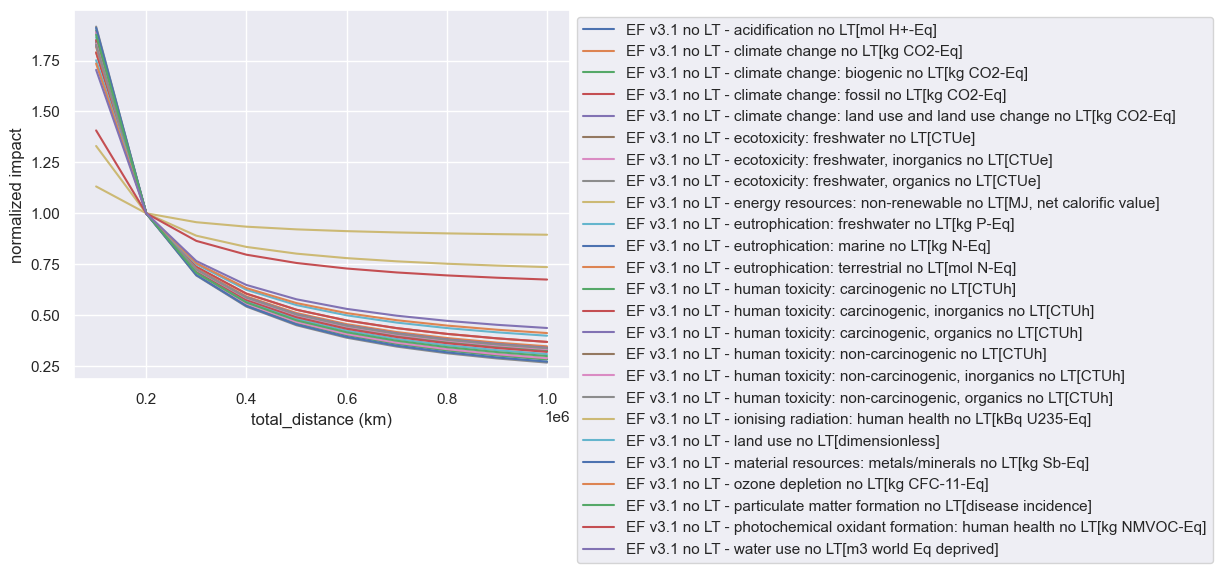

In [112]:
ax = (df_impacts/df_impacts.loc[2e5]).plot() #normalize by the reference value : 200000 km, and plot
ax.legend(bbox_to_anchor=(1, 1), loc='upper left') #put the legend on the left, otherwise we can't see the graph
ax.set_xlabel('total_distance (km)')
ax.set_ylabel('normalized impact')

### N parameters, N impact categories

Now, we will try to answer the question : what is the most influent parameter of our model ?

In [113]:
agb.list_parameters()

group,name,label,default,min,max,std,distrib,unit,db
,efficiency,efficiency,0.163,0.1,0.2,,triangle,kWh/km,tuto_EV-code
,elec_mix,elec mix,FR,,,,,,tuto_EV-code
,mass_EV,mass EV,1500,1000,2000,,triangle,kg,tuto_EV-code
,passenger_number,passenger number,2,1,4,,triangle,,tuto_EV-code
,total_distance,total distance,200000,100000,400000,,triangle,km,tuto_EV-code


For this, lca_algebraic uses Global Sensitivity Analysis (GSA). It leverages fast computation of monte-carlo approches. 

We compute Sobol indices. they represent the ratio between the variance due to a given parameter and the total variance.

Sobol indices can vary between 0 and 1. 0 meaning a parameter has no influence on the results, 1 meaning that it is the only one that has an influence.

lca_algebraic computes the variance based on the distribution we provided for every parameter

Show sobol indices 

In [114]:
agb.incer_stochastic_matrix(lifecycle_act,list_methods)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('ecoinvent-3.11', 'EF v3.1 no LT', 'acidification no LT', 'accumulated exceedance (AE) no LT')


c:\Users\VM256232\AppData\Local\miniforge3\envs\bw25\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



Processing sobol for ('ecoinvent-3.11', 'EF v3.1 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('ecoinvent-3.11', 'EF v3.1 no LT', 'climate change: biogenic no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('ecoinvent-3.11', 'EF v3.1 no LT', 'climate change: fossil no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('ecoinvent-3.11', 'EF v3.1 no LT', 'climate change: land use and land use change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('ecoinvent-3.11', 'EF v3.1 no LT', 'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Processing sobol for ('ecoinvent-3.11', 'EF v3.1 no LT', 'ecotoxicity: freshwater, inorganics no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Processing sobol for ('ecoinvent-3.11', 'EF v3.1 no LT', 'ecotoxicity: freshwater, organics no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Pr

interactive(children=(Dropdown(description='indice', options=('s1', 'st'), value='s1'), Dropdown(description='…


**NOTE** \
While the inventories created in lca_algebraic are stored in the Brightway project, the formulas and parameters are not compatible with Activity Browser Before computing impacts with vanilla Brightway2 or Activity Browser, you may use the function `freezeParams()` to update the amounts in your database for a given scenario / set of parameter values.

## 7.2. Influence of background data : uncertainty analysis

According to British statistician George Cox *"all models are wrong but some are useful"* - in that light, quantifying uncertainty makes LCA results more reliable/robust. 

One of the easiest/ most common ways to do so is to perform a [Monte Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method), a random sampling technique. Before elaborating on that, we need to understand how uncertainty information is stored in Brightway:

### Uncertainty information in Brightway

Uncertainty is stored at the level of the exchanges - remember this! So, let's have a look at a random battery exchange, for which uncerainty is defined :

In [115]:
[exc for exc in battery_prod_act.technosphere()][0].as_dict()

{'name': 'battery cell production, Li-ion, NMC811',
 'amount': 0.71359,
 'database': 'ecoinvent-3.11-cutoff',
 'location': 'CN',
 'unit': 'kilogram',
 'type': 'technosphere',
 'uncertainty type': 2,
 'loc': -0.3374467112674416,
 'scale': 0.066332495807108,
 'comment': 'Literature.',
 'pedigree': ('2', '3', '3', '1', '2', '1'),
 'reference product': 'battery cell, Li-ion, NMC811',
 'input': ('ecoinvent-3.11-cutoff', '370b15a311df01e126a9603b18c2e29b'),
 'output': ('tuto_EV-code', '2ca58142dd46428d84cb8e6a2607cf5e')}

The *necessary* uncertainty information of an exchange is described in the following fields:  
  - **'uncertainty type'** : type of probability distribution function that the exchange follows. For example, the uncertainty type = 2 indicates a `lognormal`  distribution.  
  - **'loc', 'scale', 'shape', 'minimum', 'maximum'**: parameters of the distribution function, which are respectively the location (mean $\mu$, mode, offset, or median), scale (e.g. standard deviation $\sigma$), and shape as well as minimum and maximum of the underlying distribution. Mind that different distribution functions require different parameters - not all parameters have to be defined for each distribution.

Some *additional* uncertainty related information ('scale without pedigree', 'pedigree') are also there, but are not directly used in the calculation of the uncertainty. They are also specific to ecoinvent.

Uncertainty in Brightway is dealt with using a Python package called `stats_arrays` (see [here](http://stats-arrays.readthedocs.io/en/latest/)), developed by Chris Mutel in the context of the development of Brightway but applicable to any stochastic model in Python. Have a look at it to see which probability distribution functions are available. And then, let's import this package!

In [116]:
import stats_arrays

Just to give a brief example of how the uncertainty information "works", let's have a look at the lognormal distribution. As a reminder:   
  - a random variable $X$ is a lognormal if its natural logarithm $ln(X)$ is normally distributed  
  - the natural logarithm of the *median* of the lognormal distribution is equal to the median (=mean) of the underlying distribution  

Taking the deterministic amount `amount` to be the median, we should have `loc` = `ln('amount')`. Let's do this for the first exchange of a random ecoinvent activity that has a lognormal distribution.  
>You can check it by lookiing at the uncertainty type in the activity

In [117]:
[exc for exc in battery_prod_act.technosphere()][0].as_dict()

{'name': 'battery cell production, Li-ion, NMC811',
 'amount': 0.71359,
 'database': 'ecoinvent-3.11-cutoff',
 'location': 'CN',
 'unit': 'kilogram',
 'type': 'technosphere',
 'uncertainty type': 2,
 'loc': -0.3374467112674416,
 'scale': 0.066332495807108,
 'comment': 'Literature.',
 'pedigree': ('2', '3', '3', '1', '2', '1'),
 'reference product': 'battery cell, Li-ion, NMC811',
 'input': ('ecoinvent-3.11-cutoff', '370b15a311df01e126a9603b18c2e29b'),
 'output': ('tuto_EV-code', '2ca58142dd46428d84cb8e6a2607cf5e')}

### Basic Monte Carlo simulation

**One functional unit, one impact category**

In [118]:
ipcc2013 = [m for m in bd.methods if 'IPCC 2013 no LT' in str(m)
                        and 'GWP100' in str(m)][0]
ipcc2013

('ecoinvent-3.11',
 'IPCC 2013 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

**NOTE** : above we parametrized our inventory and made the calculations using ***lca_algebraic*** library.

If you want to use ***brightway2*** calculation functions, like MonteCarlo, you first need to freeze the parameters with `agb.freezeParams()`

In [119]:
agb.freezeParams?

Signature: agb.freezeParams(db_name, **params: Dict[str, float])
Docstring:
Freezes amounts in all exchanges for a given set of parameter values.
The formulas are computed and the 'amount' attributes are set with the result.

This enables parametric datasets to be used by standard, non-parametric tools of Brightway2 (like Activities browser).

Parameters
----------
db_name :
    Name of the database for freeze (your foreground db usually)

params:
    All other parameters of this function are threated as the values of *lca_algebraic* parameters to be set.
    The default values will be used for the *lca_algebraic* parameters not mentioned here.

Examples
--------

>>> freezeParams("USER_DB", p1=0.1, p2=3.0)
File:      c:\users\vm256232\appdata\local\miniforge3\envs\bw25\lib\site-packages\lca_algebraic\params.py
Type:      function

In our case, we will perform Monte Carlo on the battery production activity, which is not parametrized, therefore we don't need to do it. Let's continue :

In [131]:
#MC simulation with 10 iterations for our battery production and the IPCC GWP100a method
mc = bc.LCA({battery_prod_act:1},  ipcc2013, use_distributions=True)
mc.lci()
mc.lcia()
scores = [mc.score for _ in zip(mc, range(10))]
scores

[24.246059601235014,
 23.27308029041707,
 24.367497949474597,
 25.99078324122017,
 25.10654057133468,
 25.859694700249786,
 26.960372702788945,
 23.974853225042242,
 23.750001756083968,
 22.4693486603245]

Let's print the results of our MC:

Well, this doesn't really look like anything yet. We should increase the number of iterations - which yields more robust results. Around 10,000 iterations is a good starting point. However, this takes a while, so we will just give it a try with 1000 now. See for yourself how long it would take for a higher number of iterations.

In [132]:
#define the number of iterations
n_runs = 1000

In [ ]:
%%time
scores = [mc.score for _ in zip(mc, range(1000))]

TypeError: '<=' not supported between instances of 'NoneType' and 'NoneType'

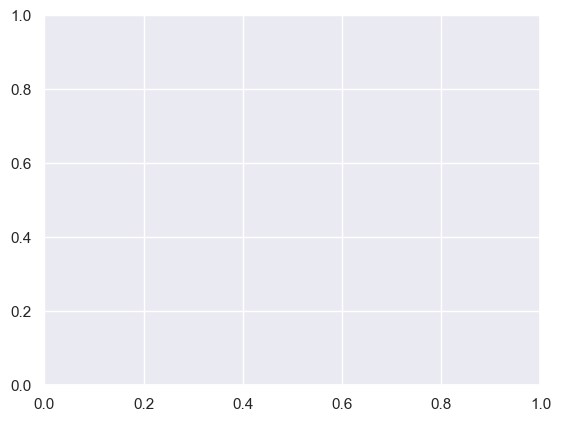

In [ ]:
plt.hist(scores, bins=40)

**One functional unit, multiple impact categories**

In [ ]:
# define the function for MC simulation
def multiImpactMonteCarloLCA(functional_unit, list_methods, iterations):
    # Step 1
    MC_lca = bc.MonteCarloLCA(functional_unit)
    MC_lca.lci()
    # Step 2
    C_matrices = {}
    # Step 3
    for method in list_methods:
        MC_lca.switch_method(method)
        C_matrices[method] = MC_lca.characterization_matrix
    # Step 4
    results = np.empty((len(list_methods), iterations))
    # Step 5
    for iteration in range(iterations):
        next(MC_lca)
        for method_index, method in enumerate(list_methods):
            results[method_index, iteration] = (C_matrices[method]*MC_lca.inventory).sum()
    return results

# define the LCIA methods, functional unit, and the number of iterations
fu = {battery_prod_act:1}
iterations = 10 #number of iterations

# let it run!
test_results = multiImpactMonteCarloLCA(fu, list_methods, iterations)
test_results

In [ ]:
#we can get the plots for all 34 ILCD methods (--> type: len(ILCD)) by changing the index in the brackets
plt.hist(test_results[1], bins=40)

# 8. Additionnal features

As a complement, here we show additionnal lca_algebraic features.

A dashboard groups all the sensitivity analysis information in a single interface with tabs.

It also shows total variation of impacts. This last graph could be improved by showing stacked colored bars with the contribution of each parameter to this variation, according to Sobol indices. 

In [ ]:
agb.incer_stochastic_dashboard(model=lifecycle_act, methods=list_methods)

One of te outcome of the statisticall analysis above would be to identify main input parameters and produce simplidied models, fixing the minor ones.

````lca_algebraic```` provide several functions for doing this.

First, let's look at the full expression defining our model

In [ ]:
expr, _ = agb.actToExpression(lifecycle_act)
expr

In [ ]:
agb.list_parameters()

We provide some method to automatically select a subset of parameters, based on the **sobol indices**, and then compute simplified models for it.

We also round numerical expression to 3 digits, and we remove terms in sums that are less than 1% of total.


In [ ]:
simplified = agb.sobol_simplify_model(
    lifecycle_act, # The model
    [list_methods[1]], # Impact(s) category(ies) to consider, could be done on the whole list (but longer)
    n=10000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0
    min_ratio=0.95, # Min ratio of variability to explain

    num_digits=3)

Let's look at the expression for first impact again 
much simpler ! 


In [ ]:
simplified[0].expr

You can also compare the simplified expression with the complete one with

In [ ]:
agb.compare_simplified(lifecycle_act, [list_methods[1]], simplified)

This feature can be useful to share simplified models for people who are not trained to brightway, as you are now ;)

# 9. Conclusion

This notebook comes to an end. Now feel free to start from scratch with the same database, and explore any parameter / scenario / visualization you want !

To start your own new project with ecoinvent 3.11 cutoff installed, you can copy the tuto project so that you don't have to re-install ecoinvent:

In [ ]:
bd.projects.set_current("ecoinvent311")
bd.projects.copy_project('your_project_name', switch=True) #copy the project and set the current project to the new one
del bd.databases['tuto_EV-ab'] #delete the foreground databases to start with a clean project containing only ecoinvent
del bd.databases['tuto_EV-code']
bd.databases #print databases

You can refer to the documentation for any clarification / additional feature :
- https://github.com/LCA-ActivityBrowser/activity-browser
- https://docs.brightway.dev/en/legacy/index.html
- https://lca-algebraic.readthedocs.io/en/stable/

How ecoinvent cutoff is built :
- https://support.ecoinvent.org/system-models

Advanced content : dynamic and prospective LCA (not compatible with bw2, need bw25 instead) :
- https://premise.readthedocs.io/en/latest/
- https://docs.brightway.dev/projects/bw-timex/en/latest/

**Back to [table of contents](#section0)?**
***